<a href="https://colab.research.google.com/github/PrivetBoBo/FootballTransferMarket/blob/main/FootballTransferMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Football Transfer Market Data Analysis**

In [ ]:
#Tải thư viện catboost vào google colab
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.0 MB/s eta 0:00:00


In [ ]:
# Thêm các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import datetime
from datetime import datetime, timedelta, date
import warnings
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#Thiết lập
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 1200)
pd.set_option('display.width', 1200)
warnings.filterwarnings("ignore")
%matplotlib inline

#Tạo viến colour
colour=['maroon','r','g','darkgreen','c','teal','b','navy','indigo','m','deeppink','orange','sienna','yellow','khaki','olive','tan','black','grey','brown']

print("Packages installed")

Packages installed


**Lấy dữ liệu**

In [ ]:
#Lấy dữ liệu file trên google drive vào google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Thêm tất cả các files trên gdrive vào dataframes và đọc nó
dataframes=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/content/gdrive/data'):
    for filename in filenames:
        file=filename.split('.')
        file=((file[0]+"_df"))
        if file !="_df":
            filepath=os.path.join(dirname,filename)
            df=pd.read_csv(filepath,sep=",",encoding = "UTF-8")
            exec(f'{file} = df.copy()')
            print(file, df.shape)
            dataframes.append(df)
print('Data imported')

appearances_df (1151986, 13)
clubs_df (411, 15)
competitions_df (43, 12)
player_valuations_df (419777, 7)
games_df (61043, 21)
game_events_df (554429, 7)
club_games_df (122086, 11)
players_df (28489, 23)
Data imported


In [ ]:
print(df)

       player_id                name  current_club_id   current_club_name country_of_citizenship    country_of_birth                     city_of_birth date_of_birth    position        sub_position   foot  height_in_cm  market_value_in_eur  highest_market_value_in_eur        agent_name contract_expiration_date current_club_domestic_competition_id     first_name    last_name         player_code                                          image_url  last_season                                                url
0         134354     Ian Raeymaekers              498         Ksc Lokeren                Belgium             Belgium                           Aalst       1/30/1995      Attack      Centre-Forward  Right             0                  NaN                      50000.0               NaN                      NaN                                  BE1            Ian  Raeymaekers     ian-raeymaekers  https://img.a.transfermarkt.technology/portrai...         2012  https://www.transfermarkt.co

In [ ]:
print(dataframes)

[          appearance_id  game_id  player_id  player_club_id  player_current_club_id        date           player_name competition_id  yellow_cards  red_cards  goals  assists  minutes_played
0         2483937_52453  2483937      52453           28095                   28095  2014-08-08         Haris Handzic            RU1             0          0      0        0              90
1         2479929_67064  2479929      67064           28095                    4128  2014-08-03  Felicio Brown Forbes            RU1             0          0      0        0              90
2         2483937_67064  2483937      67064           28095                    4128  2014-08-08  Felicio Brown Forbes            RU1             0          0      0        0              90
3         2484582_67064  2484582      67064           28095                    4128  2014-08-13  Felicio Brown Forbes            RU1             0          0      0        0              55
4         2485965_67064  2485965      67064      

**Xử lý dữ liệu**

In [ ]:
#Tính tuổi của các cầu thủ
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])

#Bỏ dòng các cầu thủ không có Ngày tháng năm sinh
players_df = players_df[players_df['date_of_birth'].isnull() == False]
now = datetime.now()
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int) 

#Tính hợp đồng còn lại của mỗi cầu thủ
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])

#Bỏ dòng các cầu thủ không có ngày tháng năm sinh
players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
now = datetime.now()
players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 

# Thêm giá trị năm cho các cầu thủ
player_valuations_df['datetime']=pd.to_datetime(player_valuations_df['datetime'], format="%Y-%m-%d")
player_valuations_df['year']=player_valuations_df['datetime'].dt.year

# Thêm năm các cầu thủ cho file appearances
appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year']=appearances_df['datetime'].dt.year

#Thêm giá trị vị trí cho các cầu thủ
position_df=players_df.copy()
position_df=position_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
player_valuations_df=player_valuations_df.merge(position_df, left_on='player_id', right_on='player_id')

#Thêm thuộc tính vị trí cho file appearances
value_df=players_df.copy()
value_df=value_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'sub_position', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
appearances_df1=value_df.merge(appearances_df, left_on='player_id', right_on='player_id')

print("Xử lý dữ liệu thành công")

Xử lý dữ liệu thành công


 **Tính tổng giá trị thị trường dựa vào dữ liệu file Clubs**

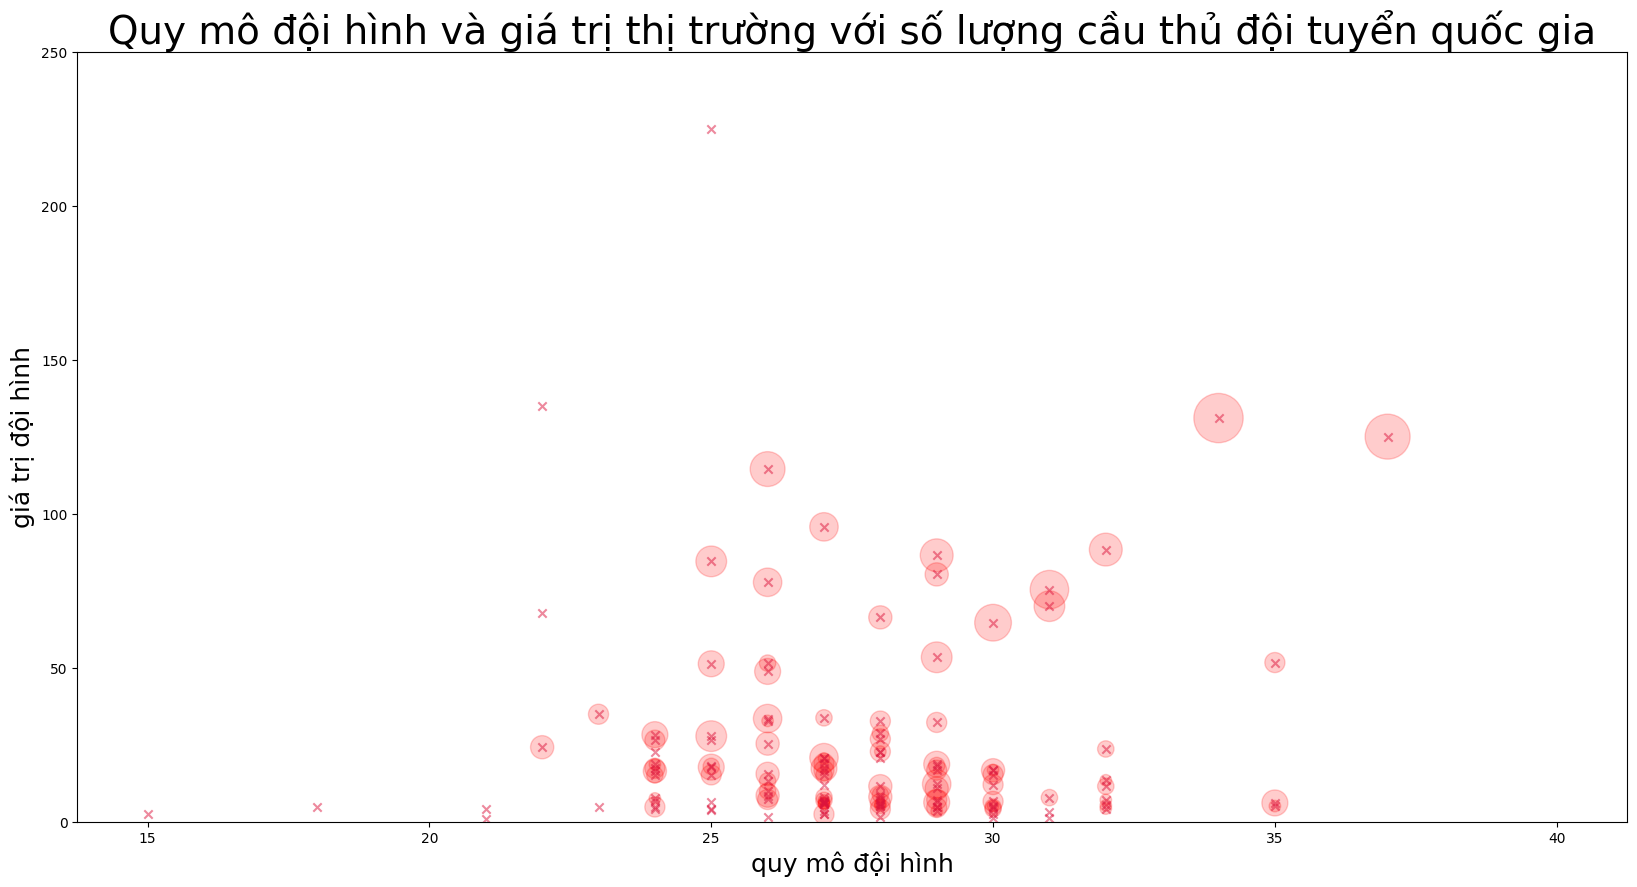

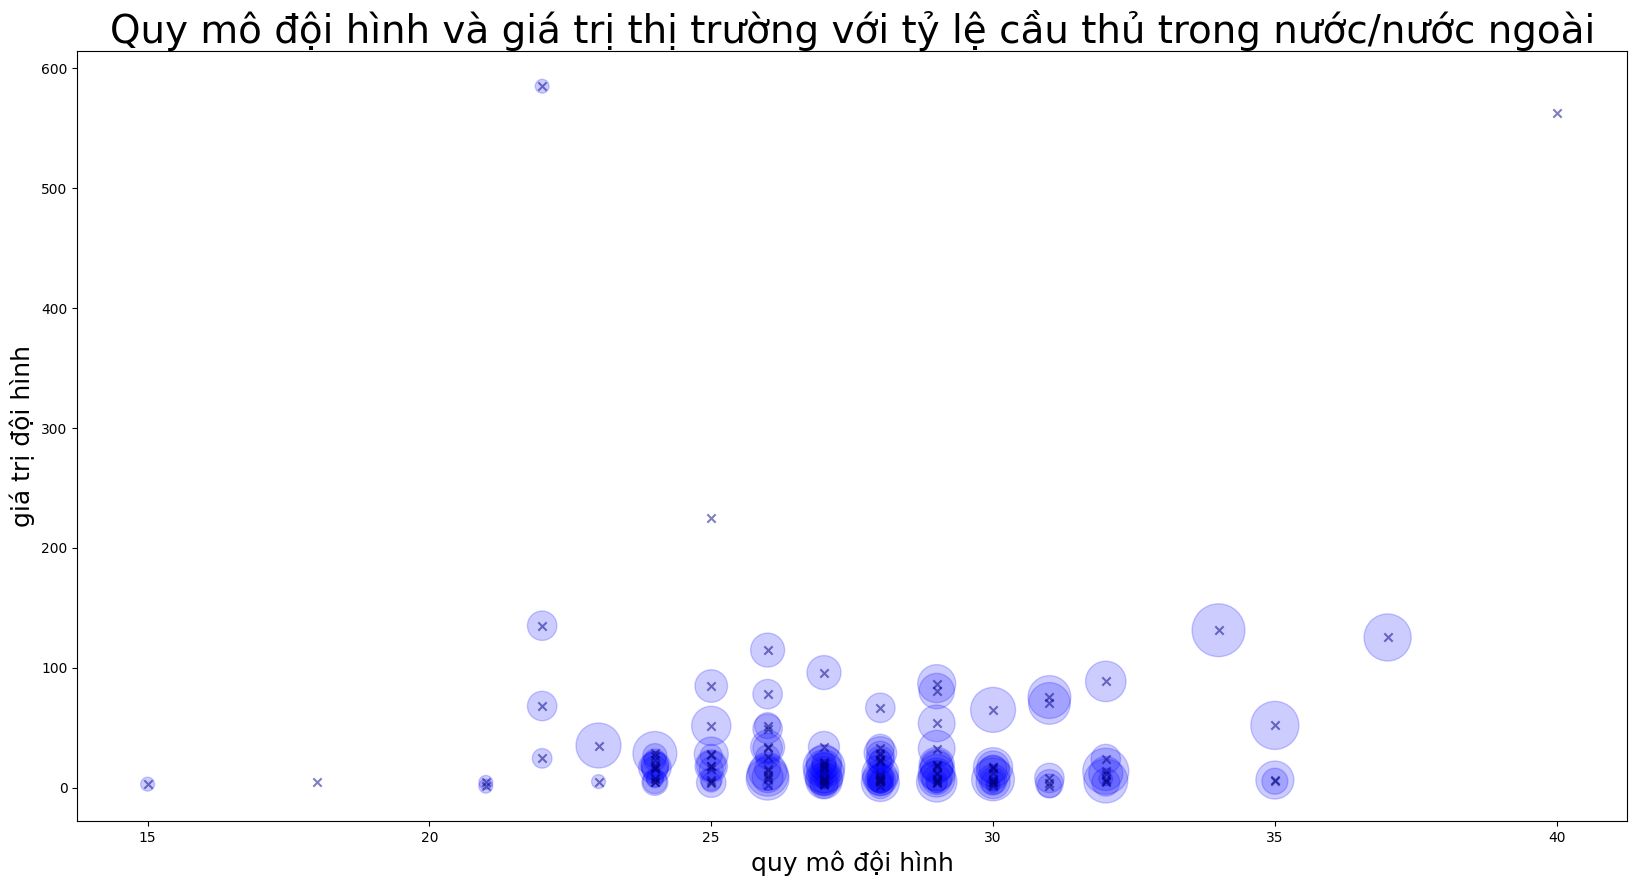

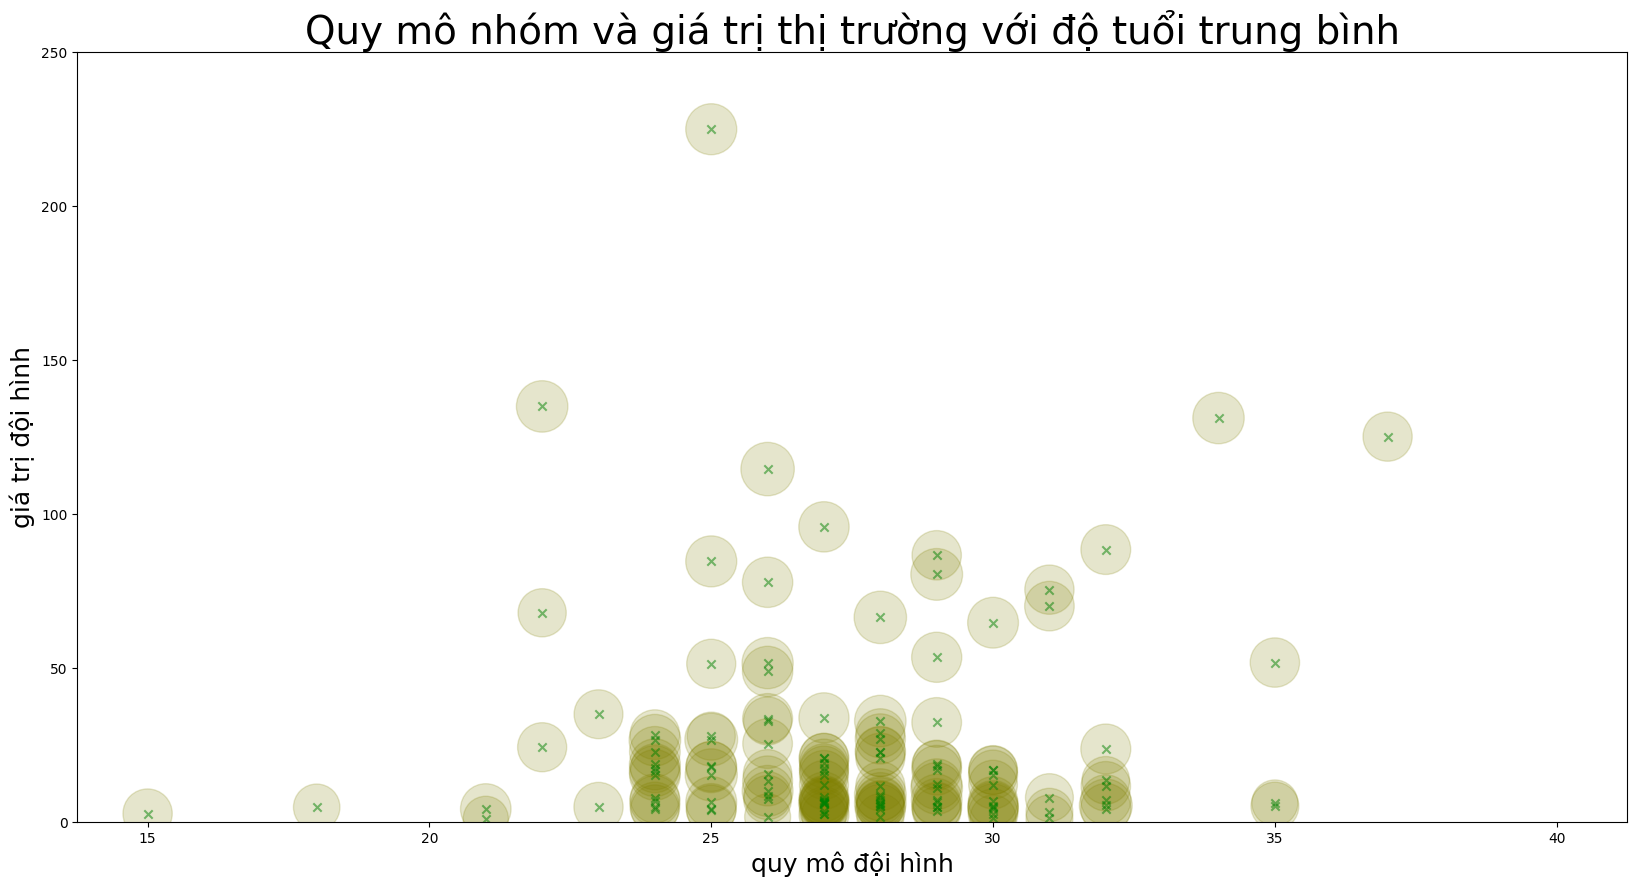

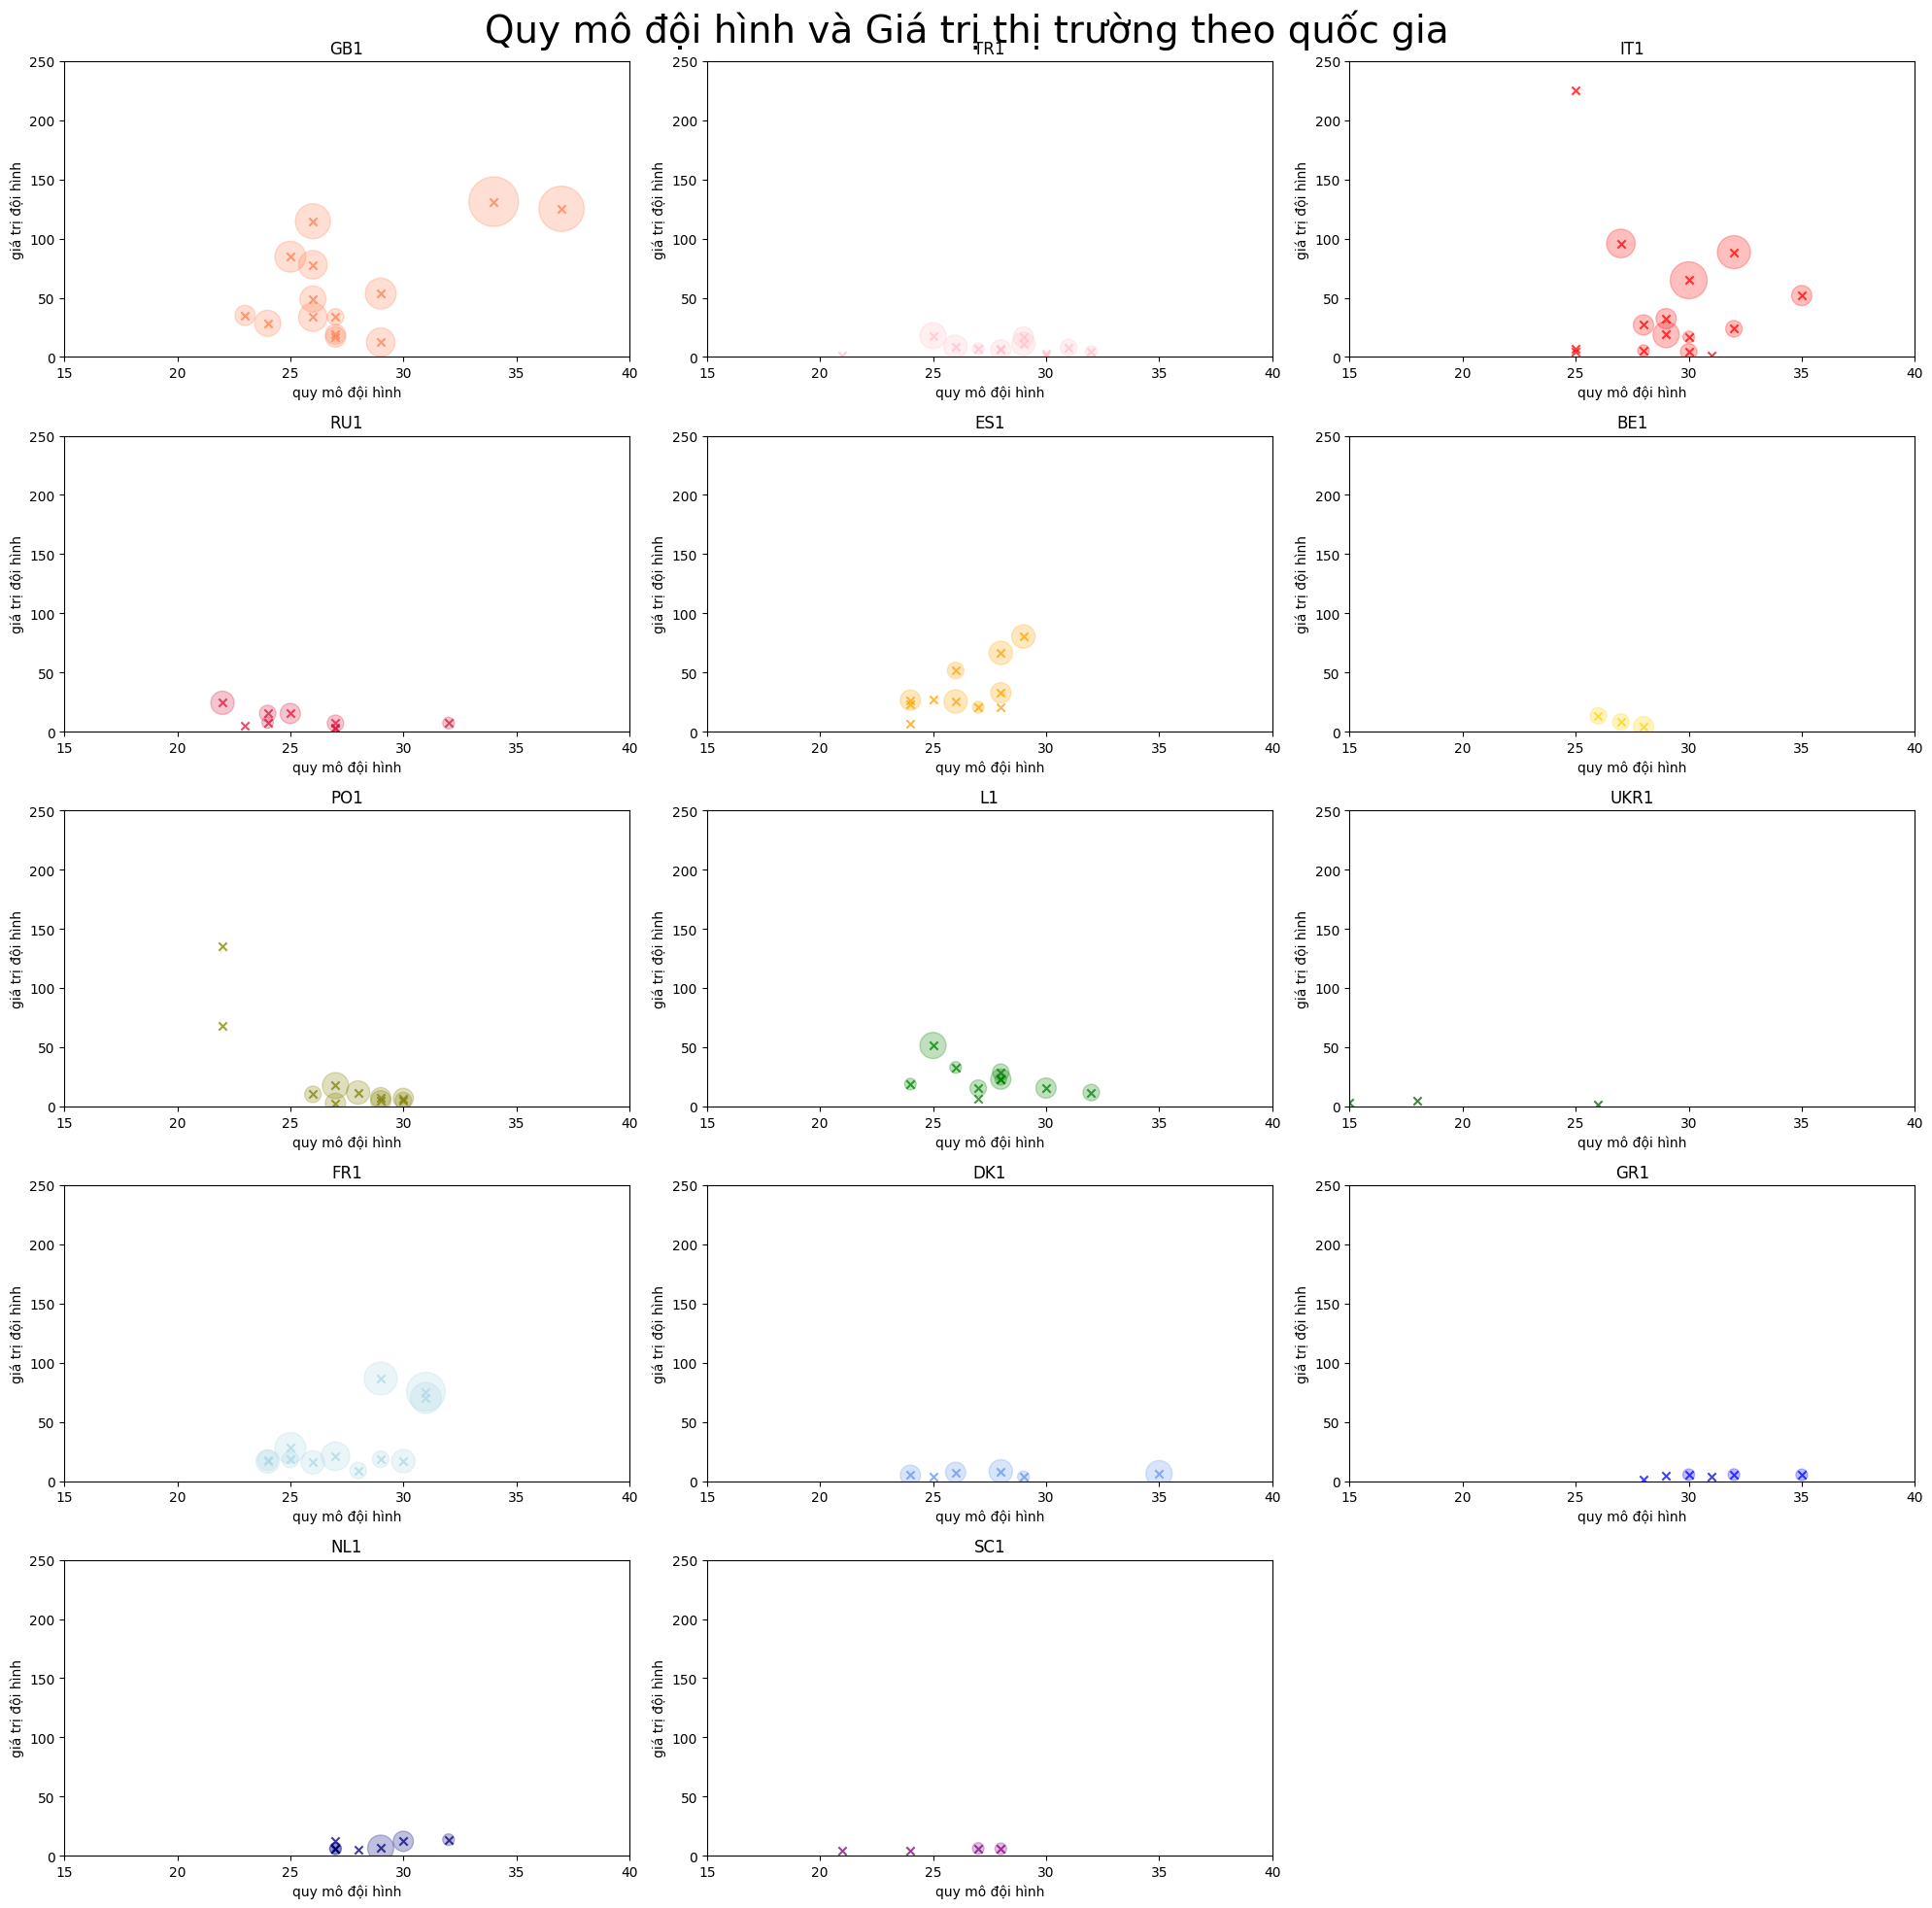

In [ ]:
# look at dataframe
#print(clubs_df.columns); print(clubs_df.shape)

# Trực quan hóa quy mô hình đội, giá trị và các cầu thủ đội tuyển
plt.figure(figsize=(20,10))
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='red',alpha=0.2, s=clubs_df['national_team_players']*70)
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='crimson',alpha=0.5, marker='x')
plt.ylim(0,250)
plt.xlabel('quy mô đội hình',fontsize=18); plt.ylabel('giá trị đội hình',fontsize=18)
plt.title('Quy mô đội hình và giá trị thị trường với số lượng cầu thủ đội tuyển quốc gia',fontsize=28)
plt.show()

# Trực quan hóa quy mô hình đội, giá trị và các cầu thủ đội tuyển
plt.figure(figsize=(20,10))
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='blue',alpha=0.2, s=clubs_df['foreigners_number']*50)
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='navy',alpha=0.5, marker='x')
plt.xlabel('quy mô đội hình',fontsize=18); plt.ylabel('giá trị đội hình',fontsize=18)
plt.title('Quy mô đội hình và giá trị thị trường với tỷ lệ cầu thủ trong nước/nước ngoài',fontsize=28)
plt.show()

# Trực quan hóa quy mô hình đội, giá trị và các cầu thủ đội tuyển
plt.figure(figsize=(20,10))
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='olive',alpha=0.2, s=clubs_df['average_age']*50)
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='green',alpha=0.5, marker='x')
plt.ylim(0,250) #;plt.xlim(15,40)
plt.xlabel('quy mô đội hình',fontsize=18); plt.ylabel('giá trị đội hình',fontsize=18)
plt.title('Quy mô nhóm và giá trị thị trường với độ tuổi trung bình',fontsize=28)
plt.show()

# Trực quan hóa quy mô hình đội, giá trị và các cầu thủ đội tuyển
n=1;colour=['coral','pink','r','crimson','orange','gold','olive','g','darkgreen','lightblue','cornflowerblue','b','navy','purple']
leagues=clubs_df.domestic_competition_id.unique()

plt.figure(figsize=(20,20))
plt.suptitle("Quy mô đội hình và Giá trị thị trường theo quốc gia", size=28)
for league in leagues:
    plt.subplot(5,3,n);n=n+1
    clubs_df1 = clubs_df[(clubs_df.domestic_competition_id==league)] 
    plt.scatter(clubs_df1['squad_size'],y=clubs_df1['total_market_value'], label=league,color=colour[n-2],alpha=0.25, s=clubs_df1['national_team_players']*75)
    plt.scatter(clubs_df1['squad_size'],y=clubs_df1['total_market_value'], color=colour[n-2],alpha=0.75, marker='x')
    plt.xlabel('quy mô đội hình'); plt.ylabel('giá trị đội hình')
    plt.ylim(0,250);plt.xlim(15,40)
    plt.title(league);
    plt.tight_layout()
plt.show()

**Trực quan hóa dữ liệu các cầu thủ trên thị trường**

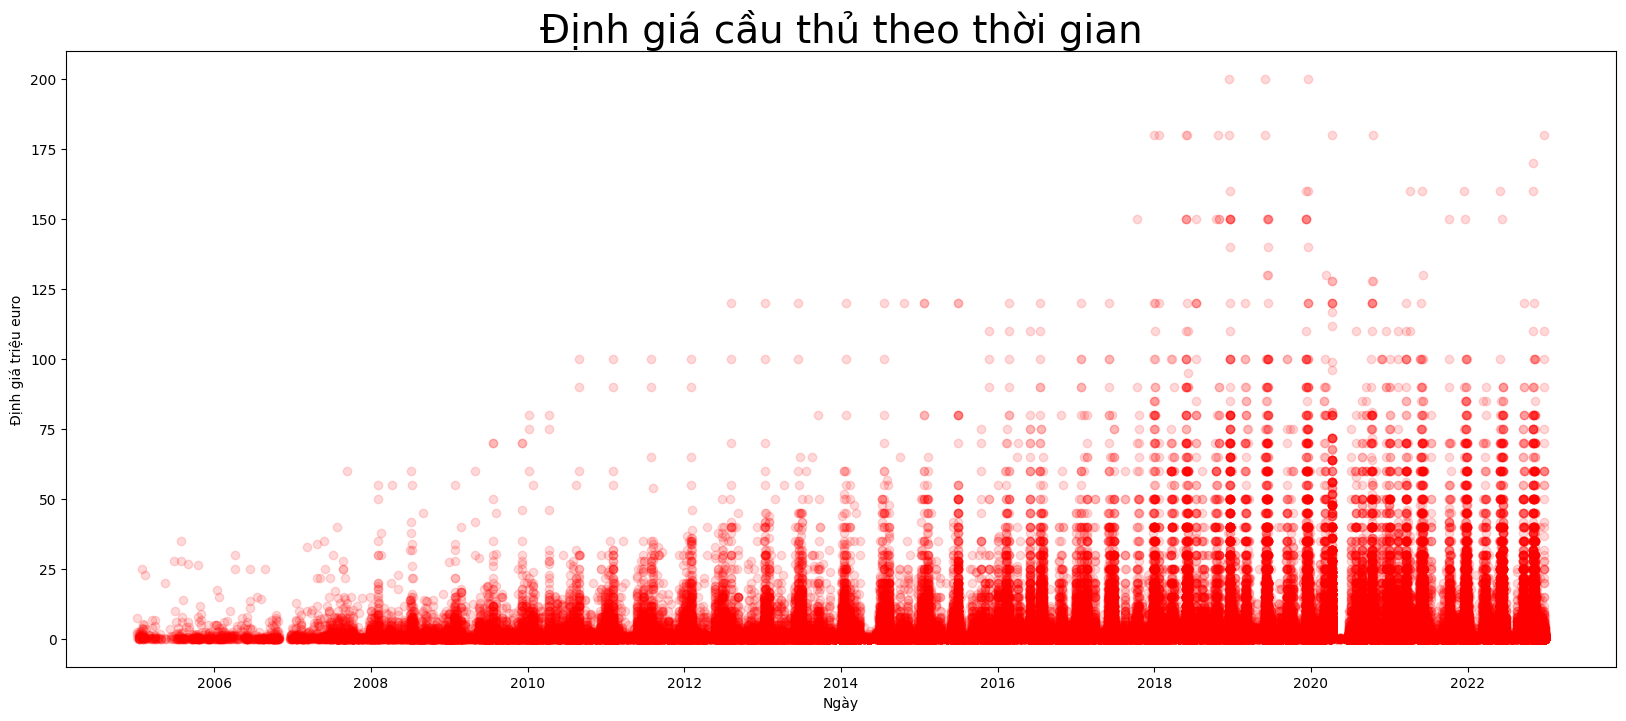

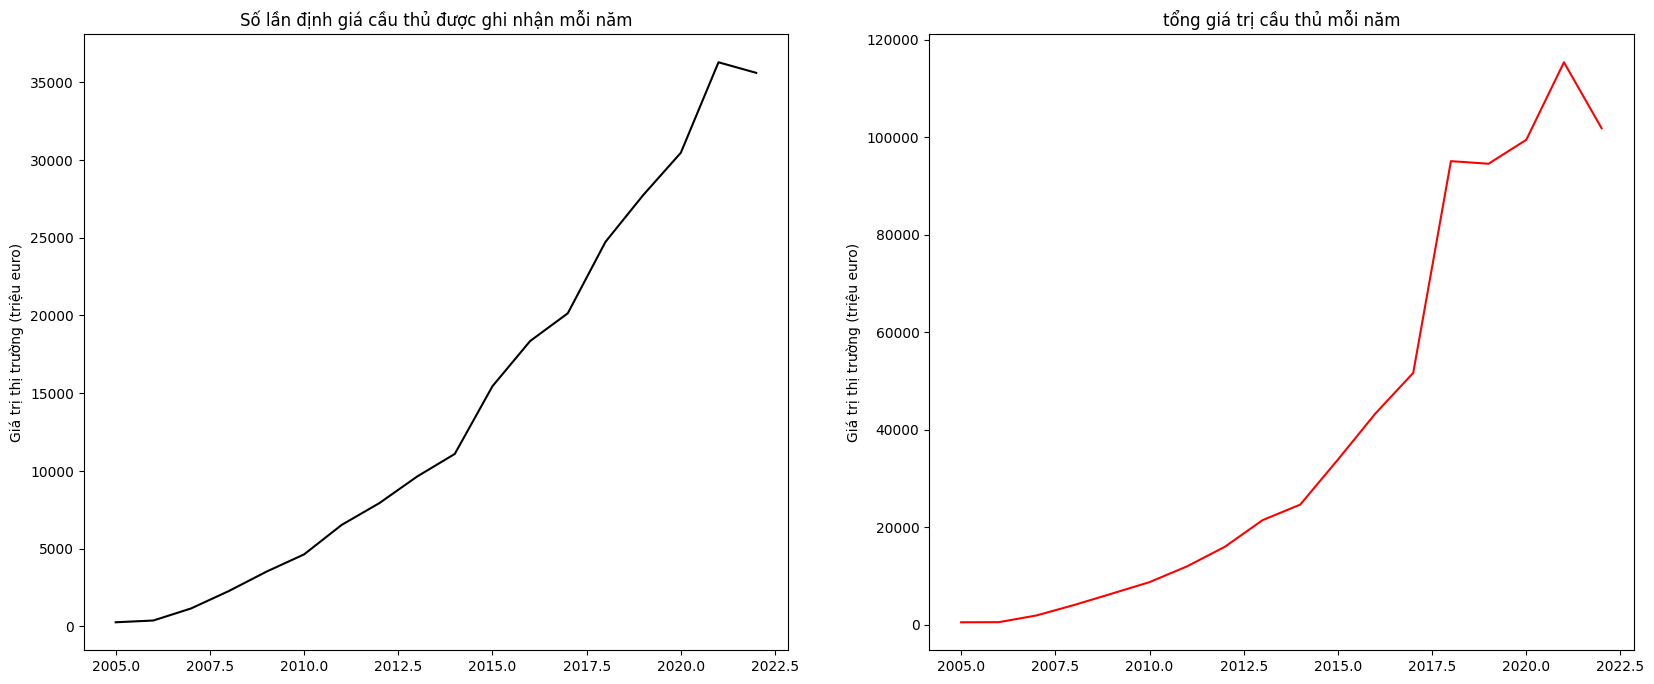

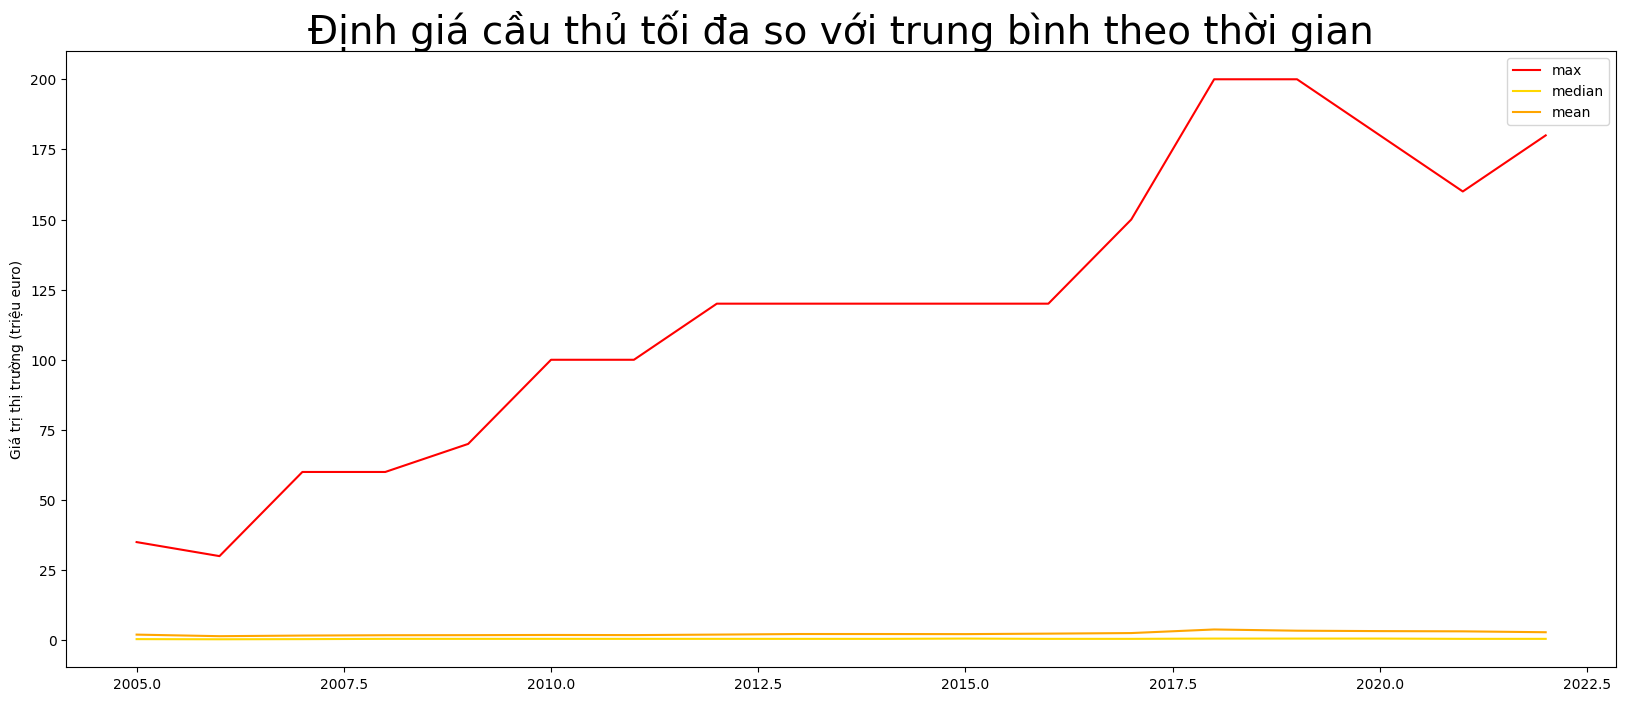

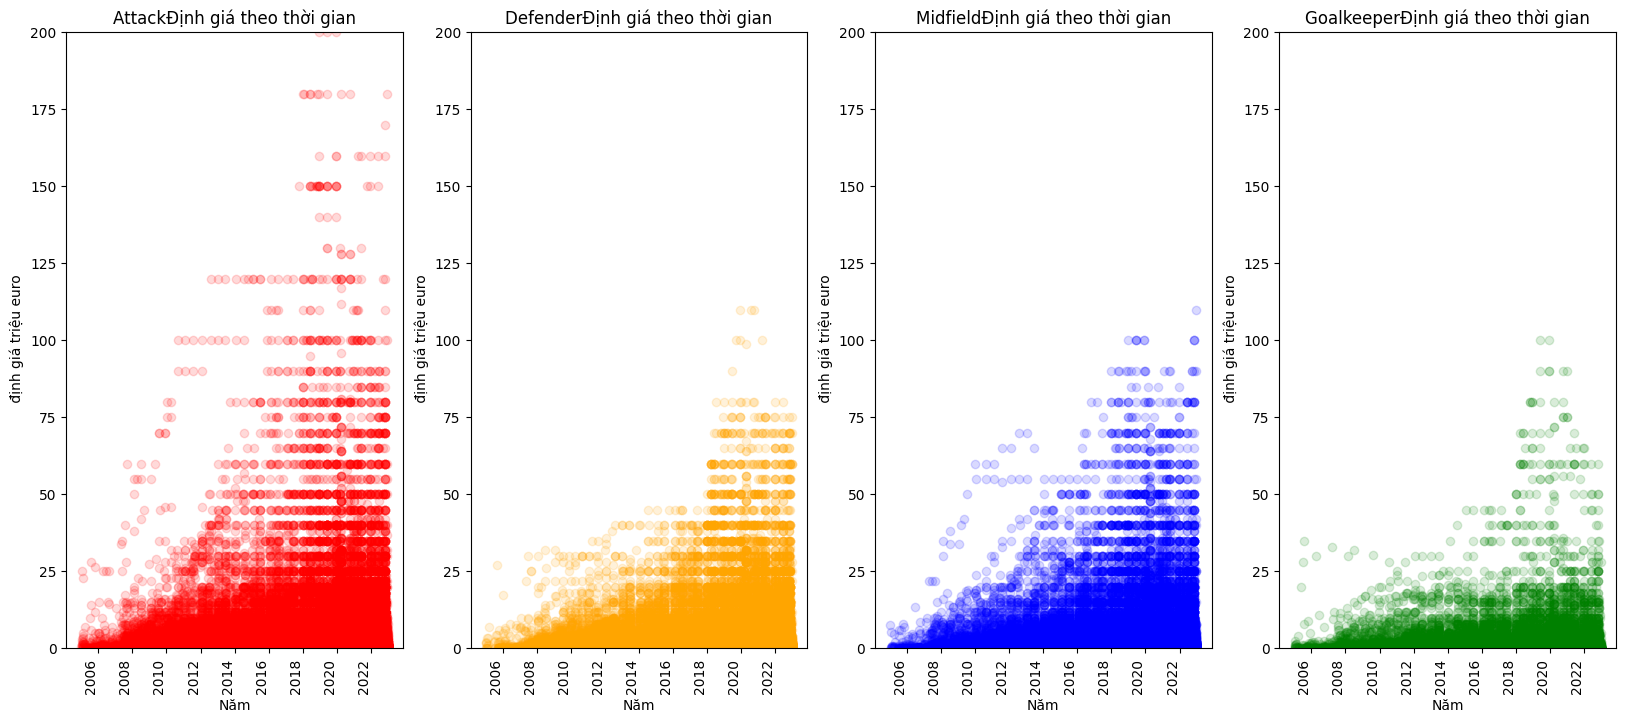

In [ ]:
#phạm vi bộ lọc
player_valuations_df = player_valuations_df[(player_valuations_df.year > 2004 ) & (player_valuations_df.year < 2023 )]
high_value_player_valuations_df = player_valuations_df[(player_valuations_df.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()

# Lookat data
#print(player_valuations_df.columns)

# Trực quan hóa dữ liệu định giá theo thời gian
plt.figure(figsize=(20,8))
plt.scatter(player_valuations_df['datetime'],y=player_valuations_df['market_value_in_eur']/1000000, c='red',alpha=0.15)
plt.xlabel('Ngày');plt.ylabel('Định giá triệu euro')
plt.title('Định giá cầu thủ theo thời gian',fontsize=28)
plt.show()

# Trực quan hóa dữ liệu định giá theo thời gian
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
yeargroups1 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).count() \
    .sort_values(by='year', ascending=True)
yeargroups2 = player_valuations_df.loc[:,['market_value_in_eur', 'year']] .groupby(['year']).sum() \
    .sort_values(by='year', ascending=True)
yeargroups3 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).max() \
    .sort_values(by='year', ascending=True)
yeargroups4 = player_valuations_df.loc[:,['market_value_in_eur', 'year']] .groupby(['year']).min() \
    .sort_values(by='year', ascending=True)
yeargroups5 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).median() \
    .sort_values(by='year', ascending=True)
yeargroups6 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).mean() \
    .sort_values(by='year', ascending=True)

plt.subplot(1, 2, 1)                 
plt.title('Số lần định giá cầu thủ được ghi nhận mỗi năm')
plt.plot(yeargroups1.index,yeargroups1,color='black')
plt.ylabel('Giá trị thị trường (triệu euro)')
plt.subplot(1, 2, 2)
plt.title('tổng giá trị cầu thủ mỗi năm')
plt.plot(yeargroups2.index,yeargroups2/1000000,color='red')
plt.ylabel('Giá trị thị trường (triệu euro)')
plt.show()
plt.figure(figsize=(20,8))
plt.title('Định giá cầu thủ tối đa so với trung bình theo thời gian',fontsize=28)
plt.plot(yeargroups3.index,yeargroups3/1000000,color='r',label='max')
plt.plot(yeargroups5.index,yeargroups5/1000000,color='Gold',label='median')
plt.plot(yeargroups6.index,yeargroups6/1000000,color='Orange',label='mean')
plt.ylabel('Giá trị thị trường (triệu euro)')
plt.legend()
plt.show()

# định giá theo vị trí
plt.figure(figsize=(20,8))
n=1;colour=['yellow','r','orange','b','g']
for position in positions:
    plt.subplot(1,4,n);n=n+1
    player_valuations_df1 = player_valuations_df[(player_valuations_df.position==position)]                                             
    plt.scatter(player_valuations_df1['datetime'],y=player_valuations_df1['market_value_in_eur']/1000000, c=colour[n-1],alpha=0.15)
    plt.xlabel('Năm')
    plt.ylabel(' định giá triệu euro')
    plt.title(position+'Định giá theo thời gian')
    plt.ylim(0,200)
    plt.xticks(rotation=90, ha='right')
plt.show()  

**Trực quan hóa dữ liệu cầu thủ**

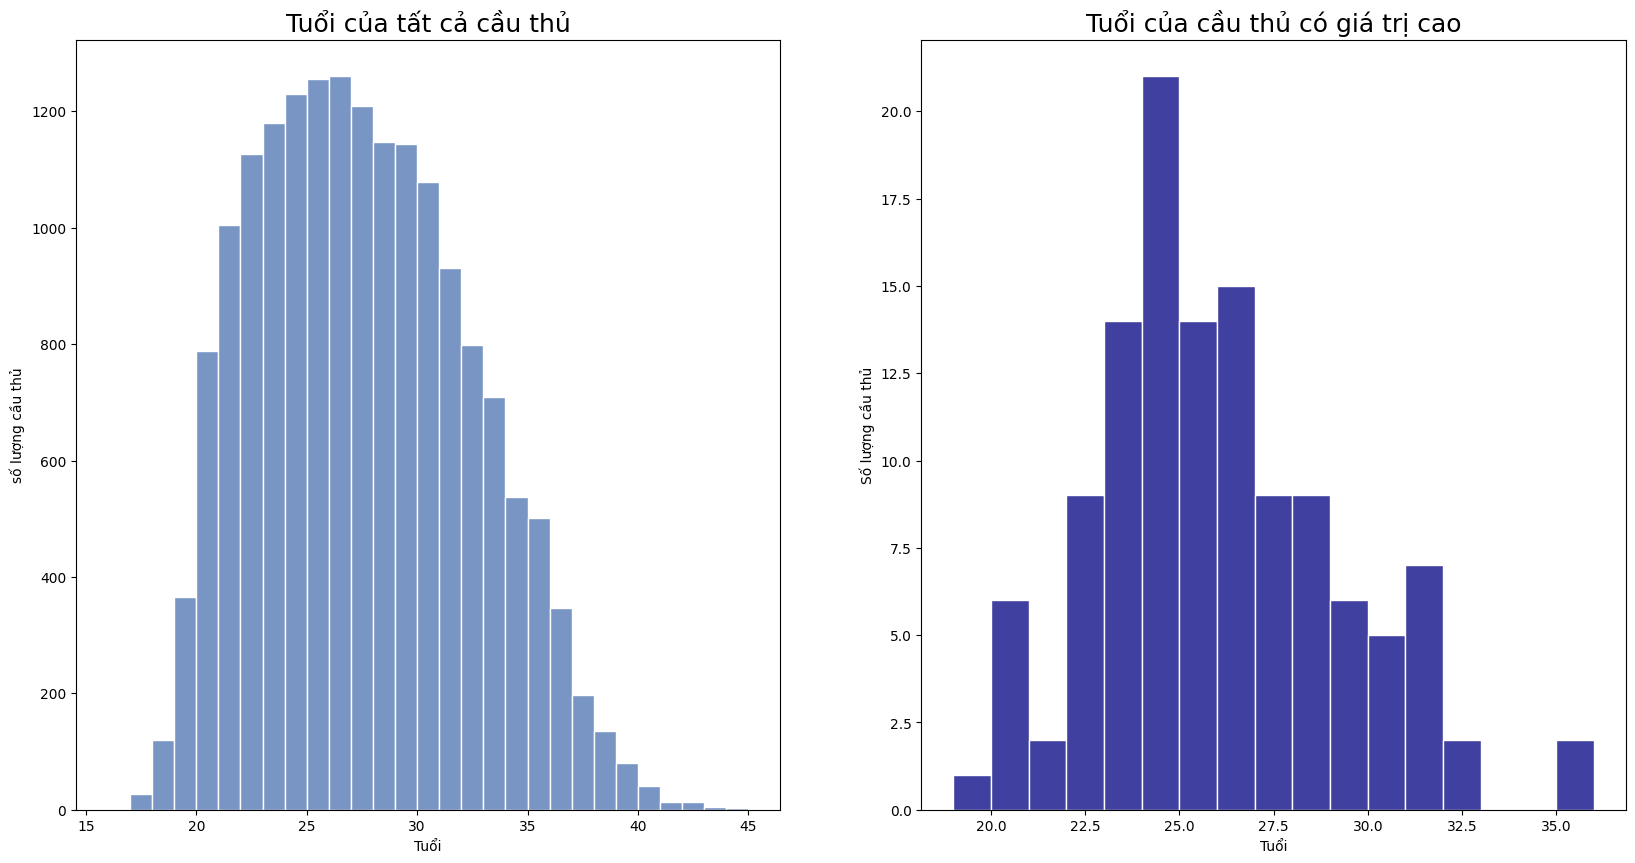

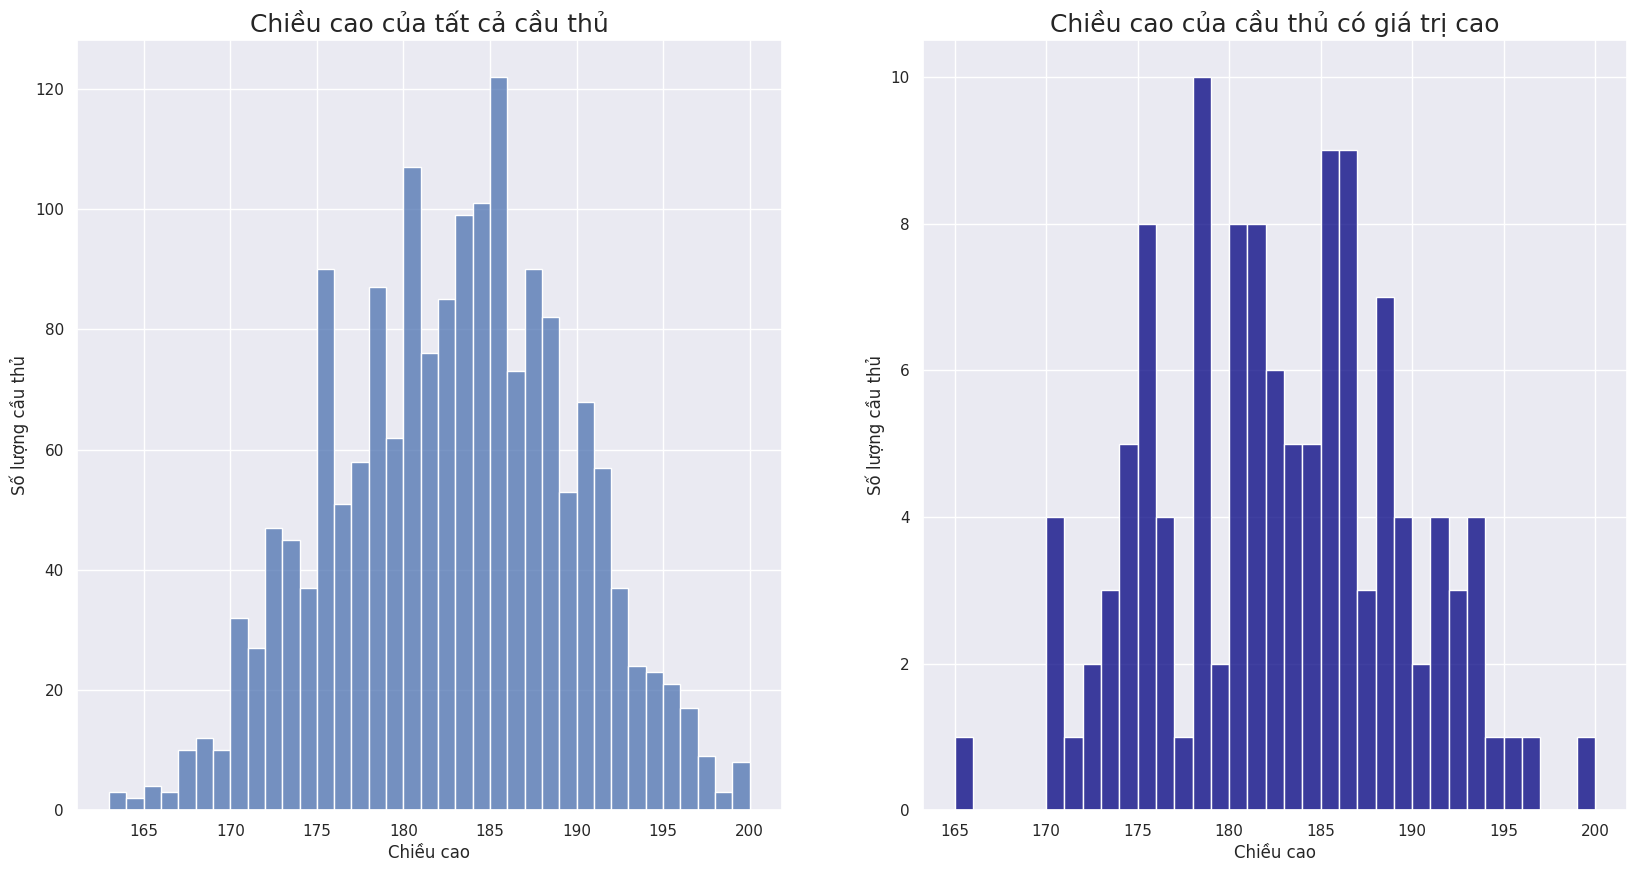

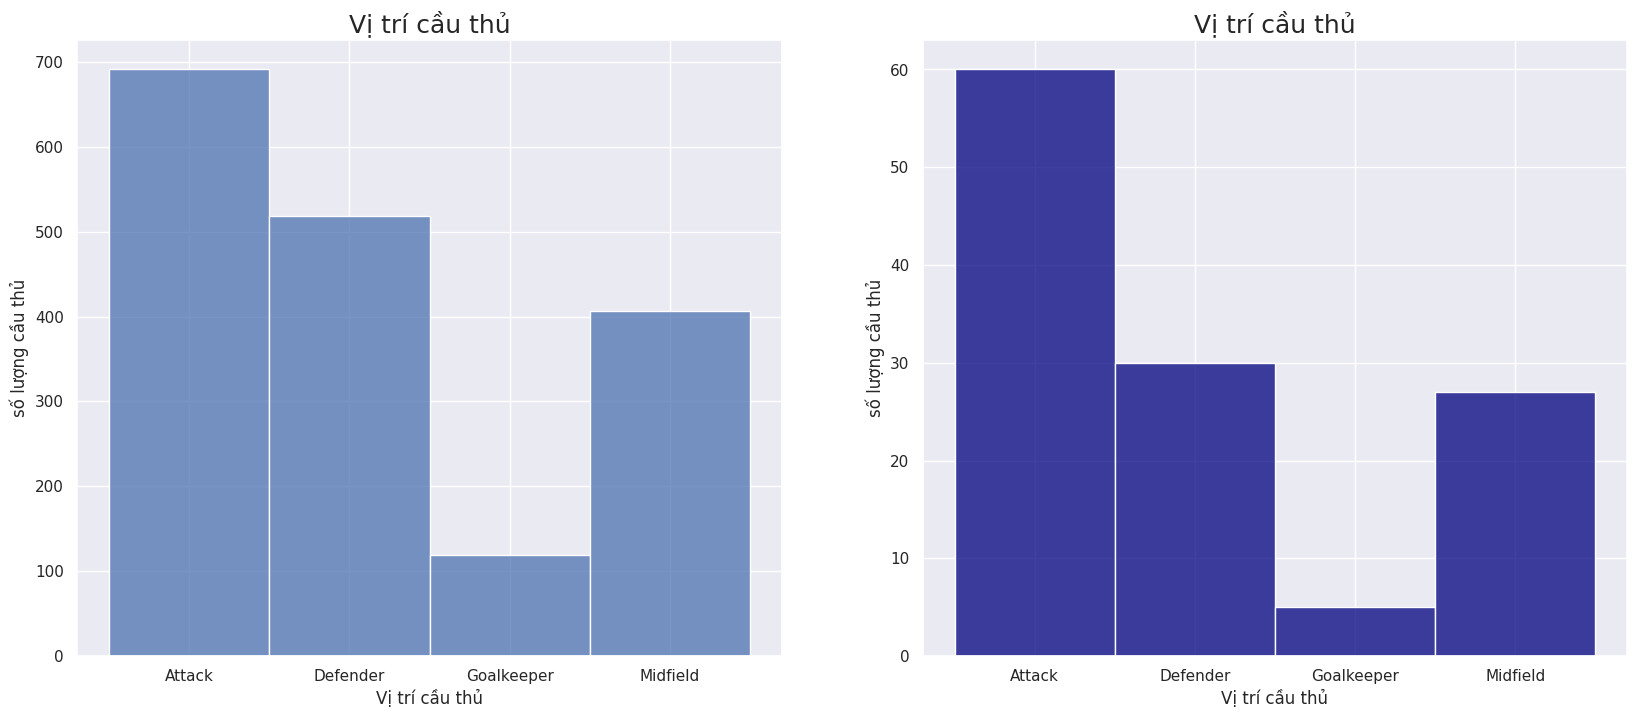

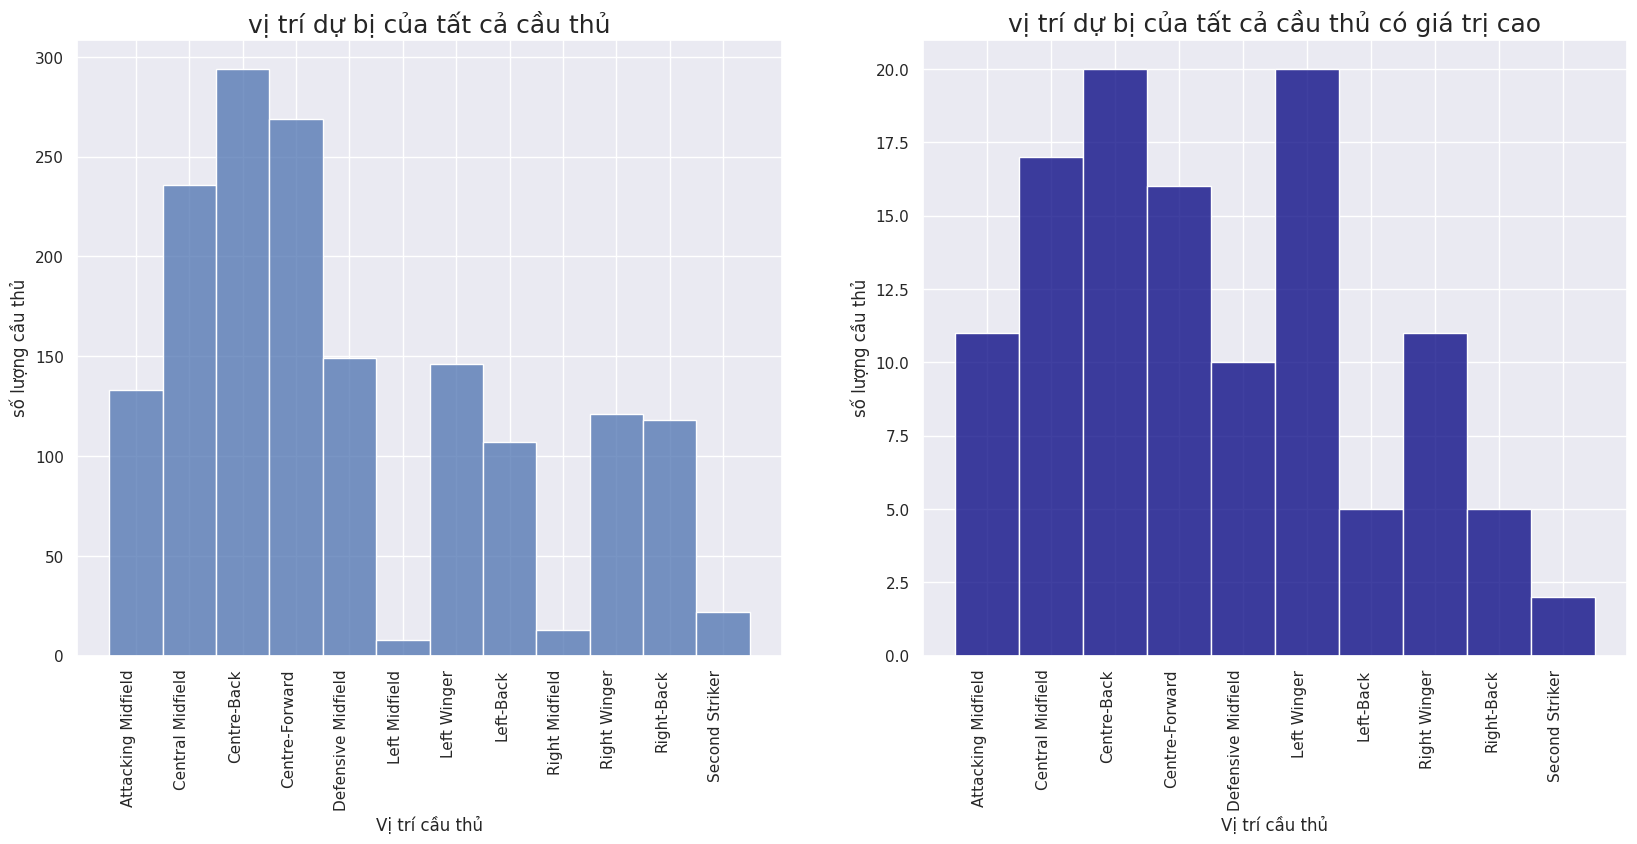

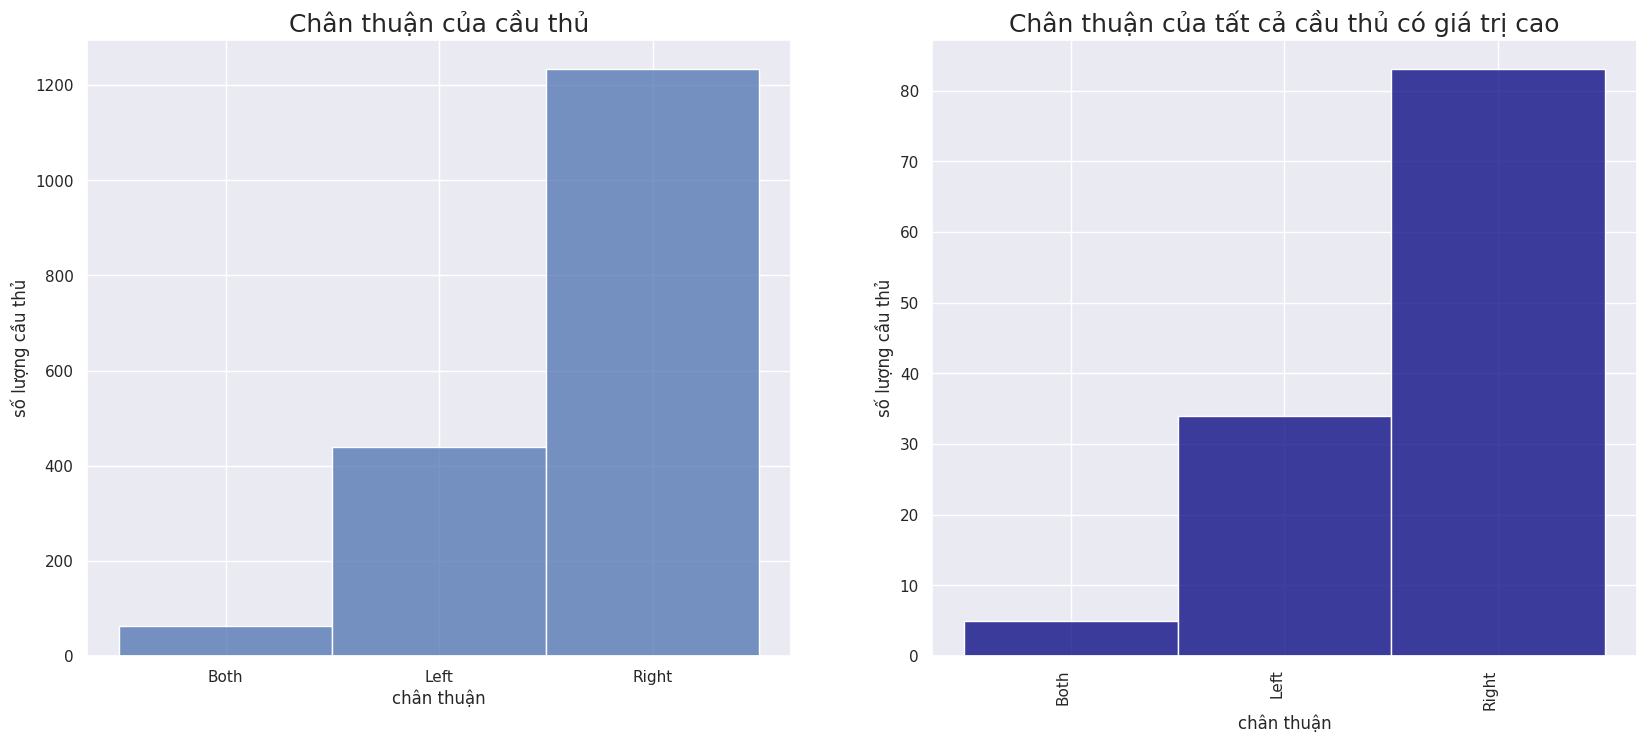

In [ ]:
#tổng quan về bộ dữ liệu cầu thủ 
#xóa cầu thủ không có giá trị trên thị trường
players_df1 = players_df[players_df.highest_market_value_in_eur.isnull() == False]
#Sắp xếp theo giá trị thị trường
players_df1 = players_df1.sort_values("highest_market_value_in_eur", ascending = False)
#lọc theo mùa và giá trị
players_df1 = players_df[players_df['last_season'] >= 2021]
players_df1 = players_df1[players_df1['highest_market_value_in_eur'] >= 10000000]
high_value_players_df = players_df1[(players_df1.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()

# Hiển thị phân bố độ tuổi của cầu thủ
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='age',data=players_df, binwidth=1,color='b')
plt.title("Tuổi của tất cả cầu thủ",fontsize=18)
plt.xlabel('Tuổi'); plt.ylabel('số lượng cầu thủ')
plt.subplot(1, 2, 2)
sns.histplot(x='age',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Tuổi của cầu thủ có giá trị cao",fontsize=18)
plt.xlabel('Tuổi'); plt.ylabel('Số lượng cầu thủ')

# Hiển thị phân bố chiều cao của cầu thủ
players_df3 = players_df1[players_df1.height_in_cm.isnull() == False]
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='height_in_cm',data=players_df3, binwidth=1,color='b')
plt.title("Chiều cao của tất cả cầu thủ",fontsize=18)
plt.xlabel('Chiều cao'); plt.ylabel('Số lượng cầu thủ')
plt.subplot(1, 2, 2)
sns.histplot(x='height_in_cm',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Chiều cao của cầu thủ có giá trị cao",fontsize=18)
plt.xlabel('Chiều cao'); plt.ylabel('Số lượng cầu thủ')

# Hiển thị dữ liệu vị trí của cầu thủ
players_df1 = players_df1.sort_values("position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
plt.title("Vị trí cầu thủ",fontsize=18);plt.grid(True)
sns.histplot(x='position',data=players_df1, binwidth=1,color='b')
plt.xlabel('Vị trí cầu thủ'); plt.ylabel('số lượng cầu thủ')
plt.subplot(1, 2, 2)
sns.histplot(x='position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("Vị trí cầu thủ",fontsize=18);plt.grid(True)
plt.xlabel('Vị trí cầu thủ'); plt.ylabel('số lượng cầu thủ')

# Hiển thị dữ liệu vị trí dự bị
players_df1 = players_df1.sort_values("sub_position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("sub_position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='sub_position',data=players_df1, binwidth=1,color='b')
plt.title("vị trí dự bị của tất cả cầu thủ",fontsize=18);plt.grid(True)
plt.xlabel('Vị trí cầu thủ'); plt.ylabel('số lượng cầu thủ')
plt.xticks(rotation=90, ha='right');
plt.subplot(1, 2, 2)
sns.histplot(x='sub_position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("vị trí dự bị của tất cả cầu thủ có giá trị cao",fontsize=18);plt.grid(True)
plt.xlabel('Vị trí cầu thủ'); plt.ylabel('số lượng cầu thủ')
plt.xticks(rotation=90, ha='right');

# Hiện dữ liệu chân thuận các cầu thủ
players_df1 = players_df1.sort_values("foot", ascending = True)
high_value_players_df1 = high_value_players_df1.sort_values("foot", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='foot',data=players_df1, binwidth=1,color='b')
plt.title("Chân thuận của cầu thủ",fontsize=18);plt.grid(True)
plt.xlabel('chân thuận'); plt.ylabel('số lượng cầu thủ')
plt.subplot(1, 2, 2)
sns.histplot(x='foot',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("Chân thuận của tất cả cầu thủ có giá trị cao",fontsize=18);plt.grid(True)
plt.xlabel('chân thuận'); plt.ylabel('số lượng cầu thủ')
plt.xticks(rotation=90, ha='right');

**Trực quan hóa dữ liệu appearances**

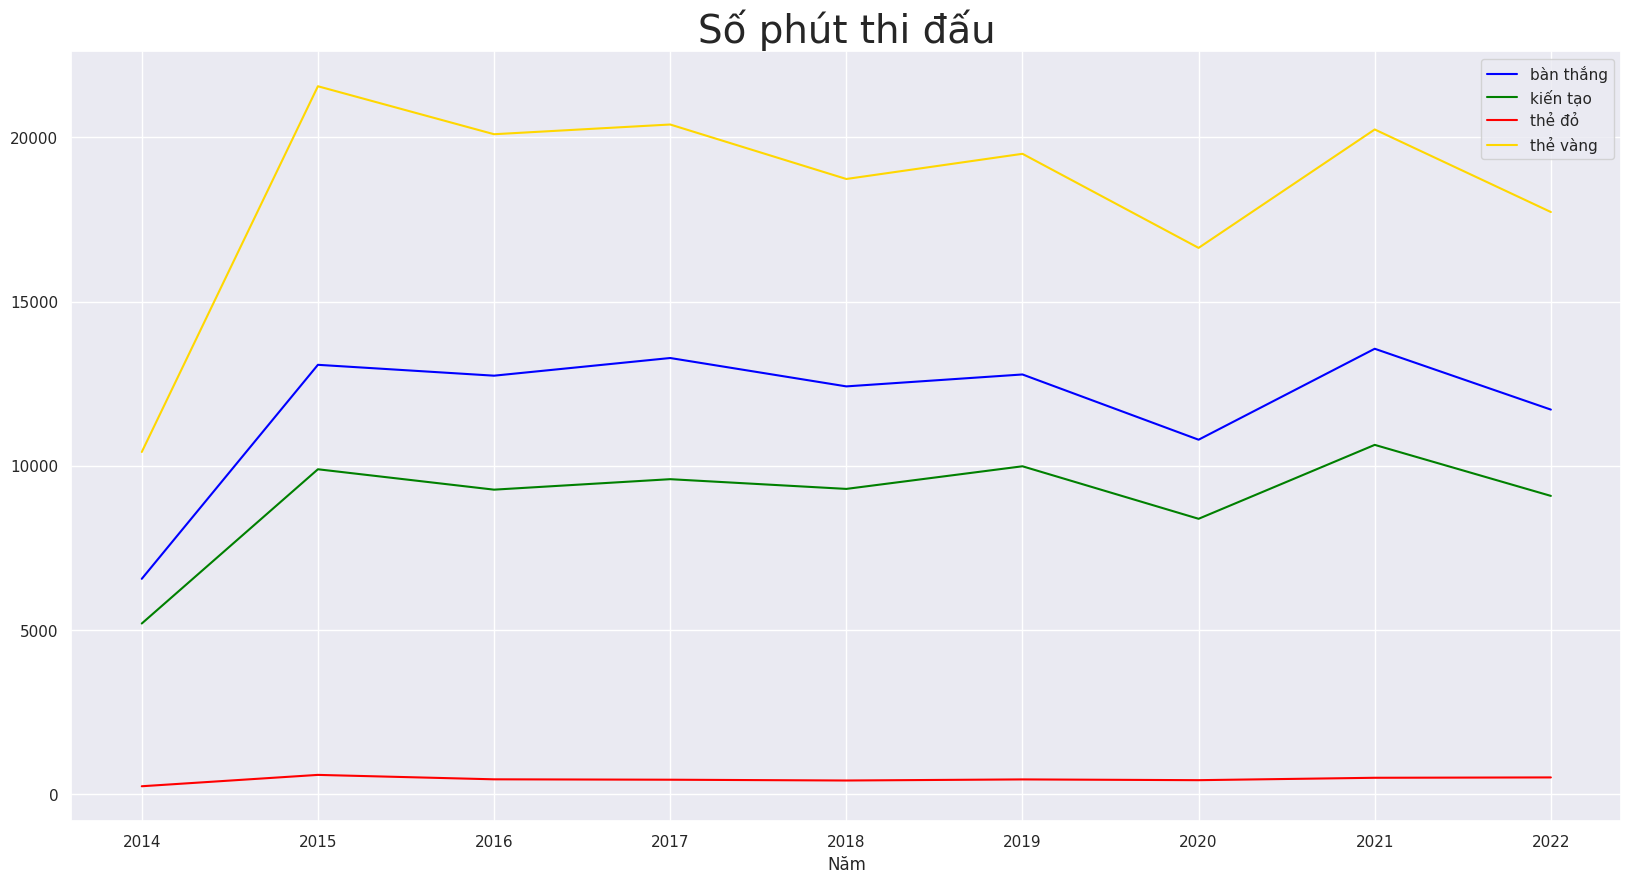

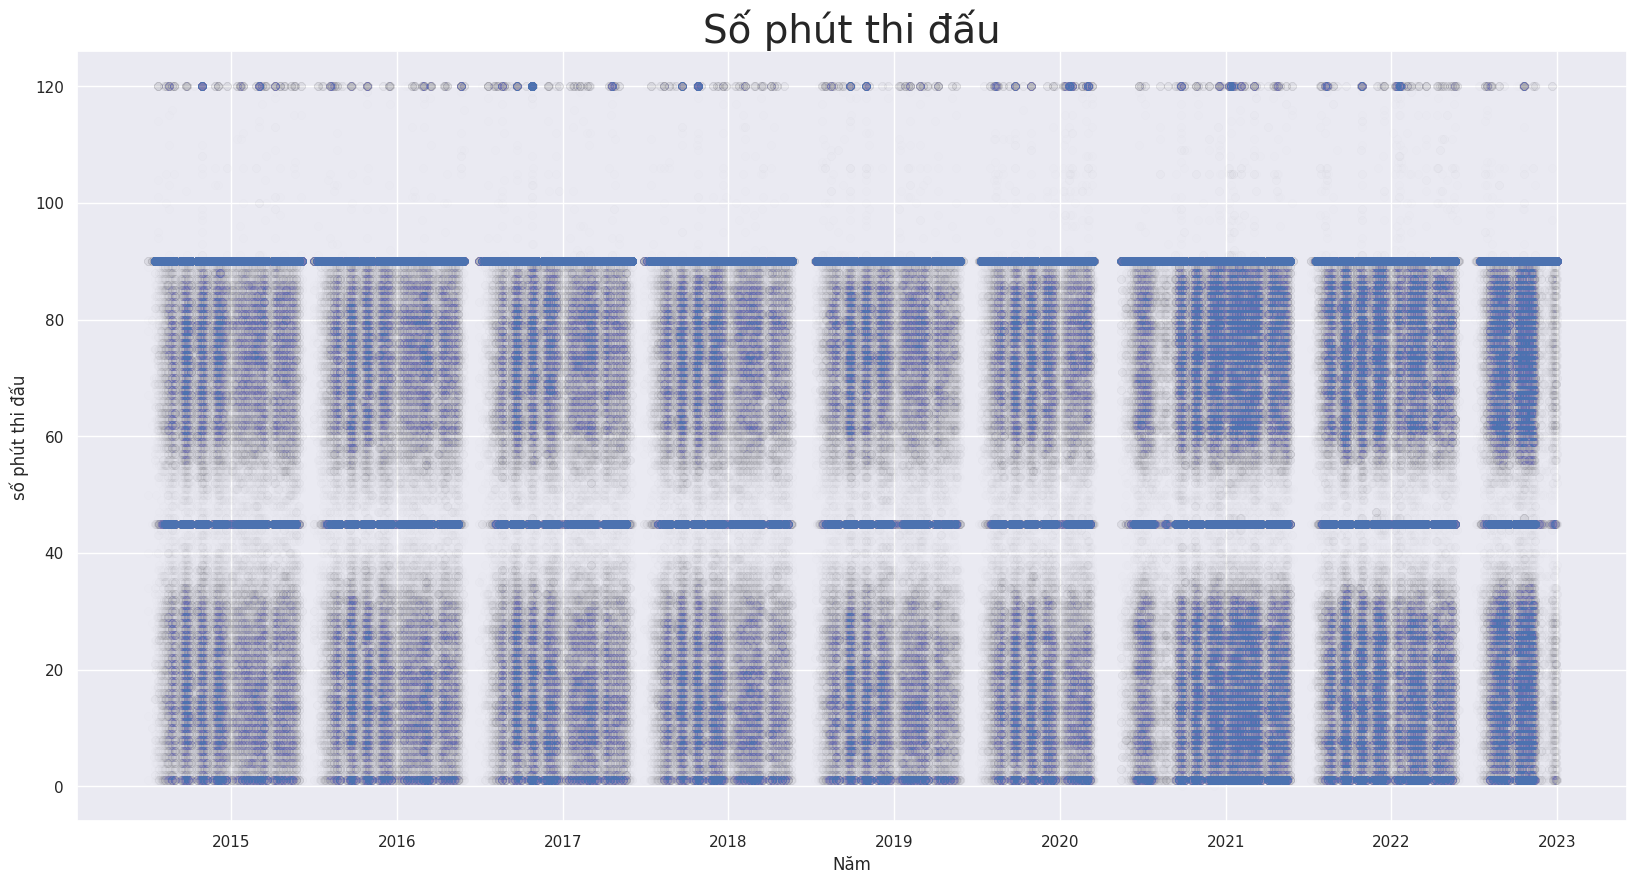

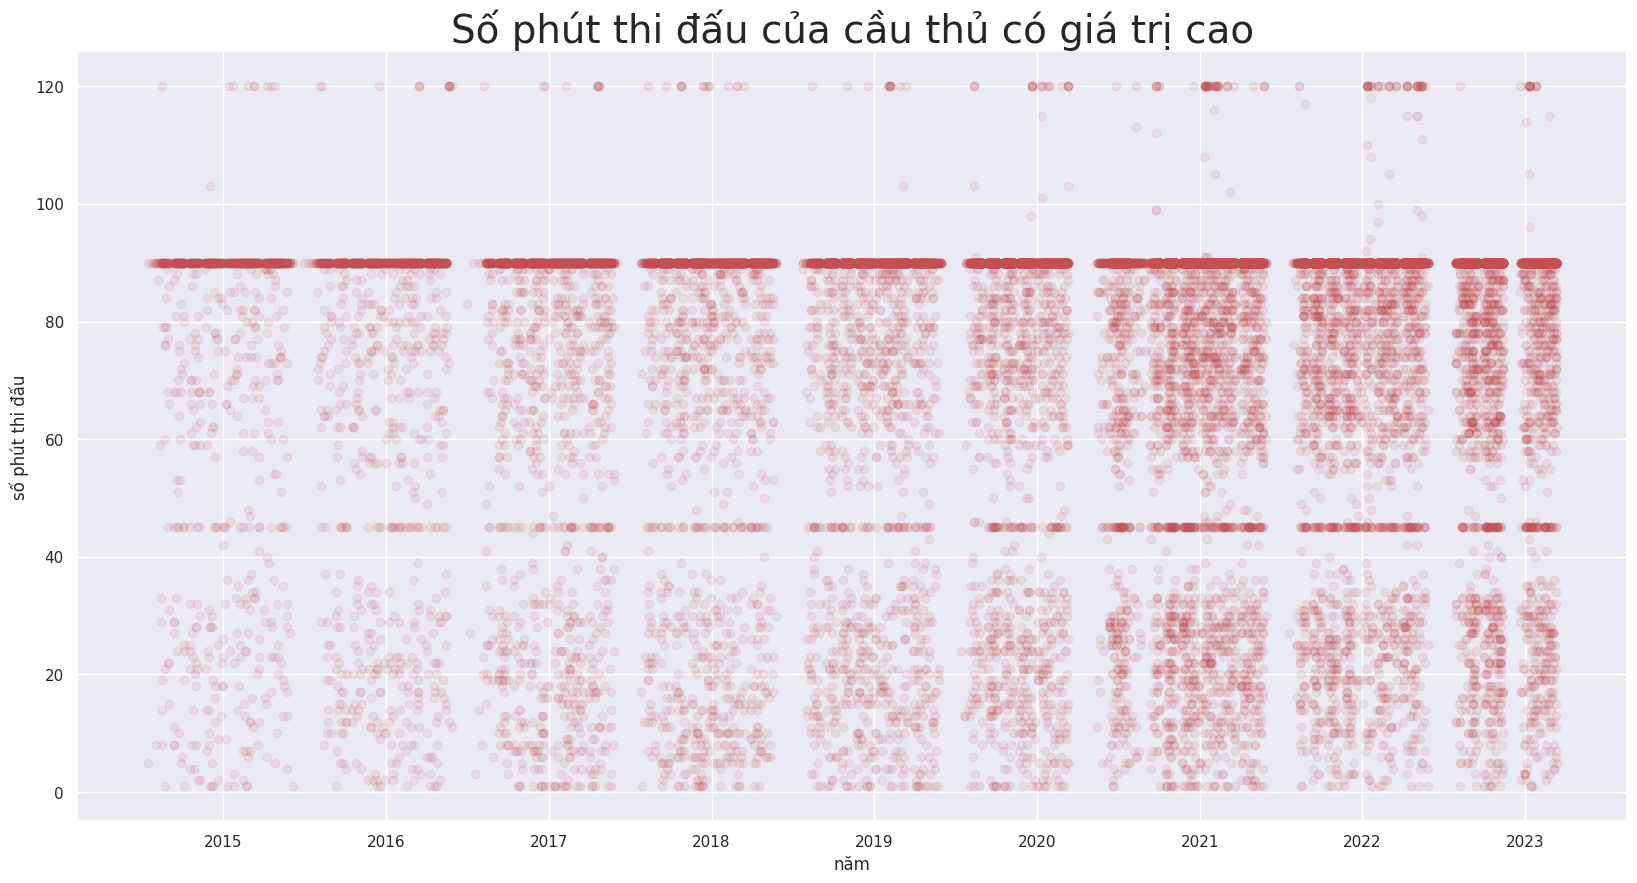

In [ ]:
#print(appearances_df.columns); print(appearances_df.shape)

#phạm vi bộ lọc
appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
high_value_appearances_df = appearances_df1[(appearances_df1.market_value_in_eur > 40000000 )]

#Hiện dữ liệu về số bàn thắng, kiến tạo, số thẻ phạt
yeargroups1 = appearances_df.loc[:,['goals', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups2 = appearances_df.loc[:,['assists', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups3 = appearances_df.loc[:,['red_cards', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups4 = appearances_df.loc[:,['yellow_cards', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
plt.plot(yeargroups1.index,yeargroups1,color='blue',label='bàn thắng')
plt.plot(yeargroups2.index,yeargroups2,color='green',label='kiến tạo')
plt.plot(yeargroups3.index,yeargroups3,color='red',label='thẻ đỏ')
plt.plot(yeargroups4.index,yeargroups4,color='gold',label='thẻ vàng')
plt.xlabel("Năm")
plt.title('Số phút thi đấu',fontsize=28);plt.legend()
plt.show()

# Khảo sát số phút thi đấu 
plt.scatter(appearances_df['datetime'],y=appearances_df['minutes_played'],alpha=0.0025,color='b')
plt.xlabel("Năm");plt.ylabel('số phút thi đấu')
plt.title('Số phút thi đấu',fontsize=28)
plt.show()

# Khảo sát số phút thi đấu
plt.scatter(high_value_appearances_df['datetime'],y=high_value_appearances_df['minutes_played'],alpha=0.1,color='r')
plt.xlabel("năm");plt.ylabel('số phút thi đấu')
plt.title('Số phút thi đấu của cầu thủ có giá trị cao',fontsize=28)
plt.show()

**Trực quan hóa dữ liệu của file Games**

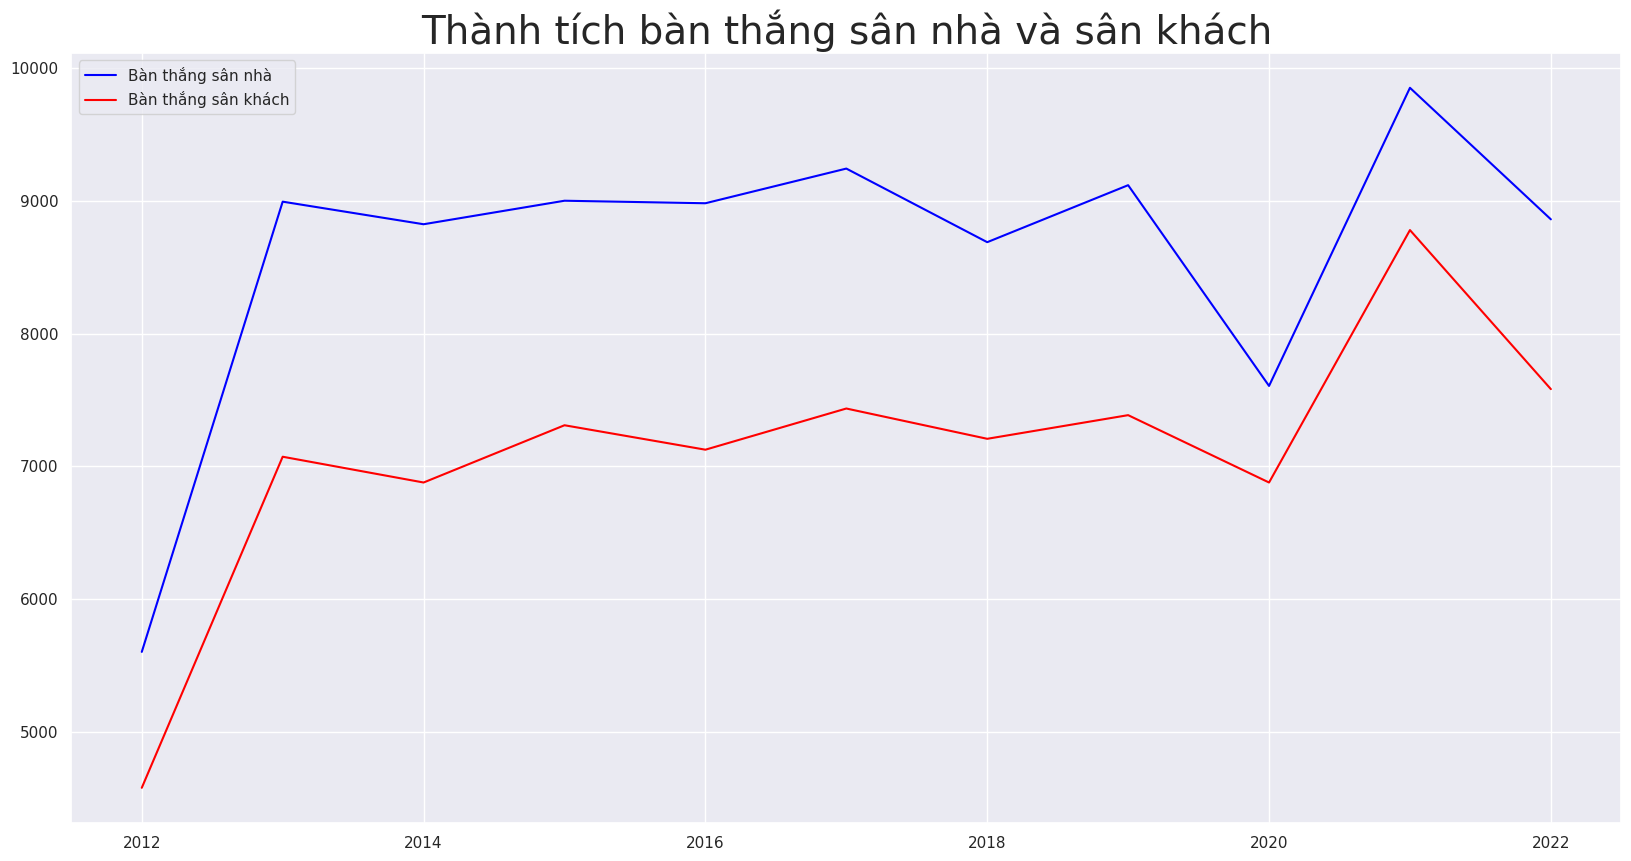

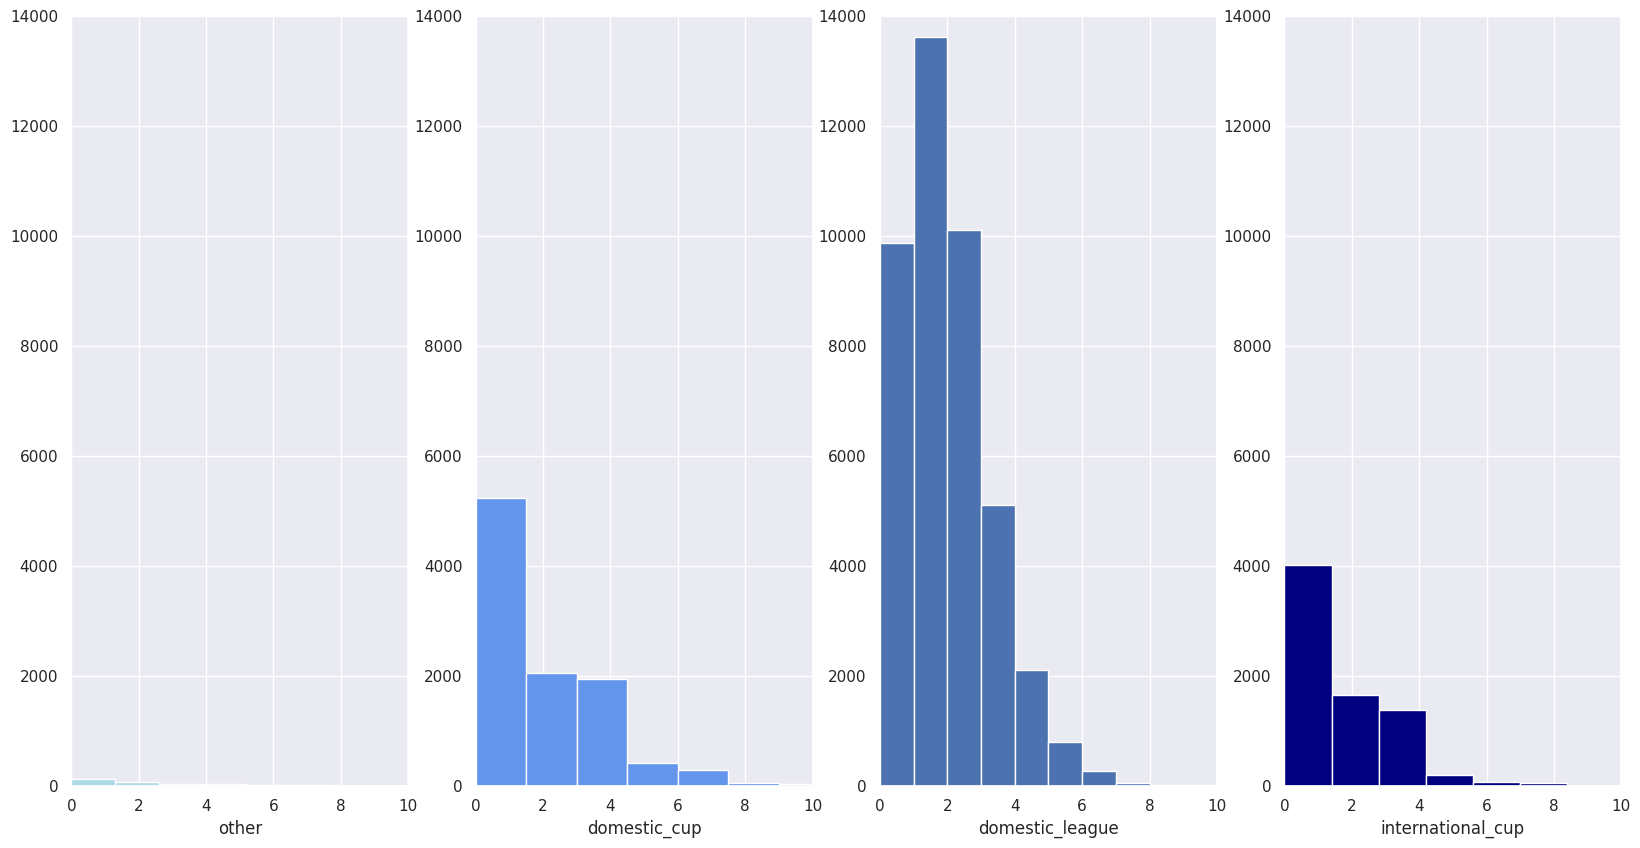

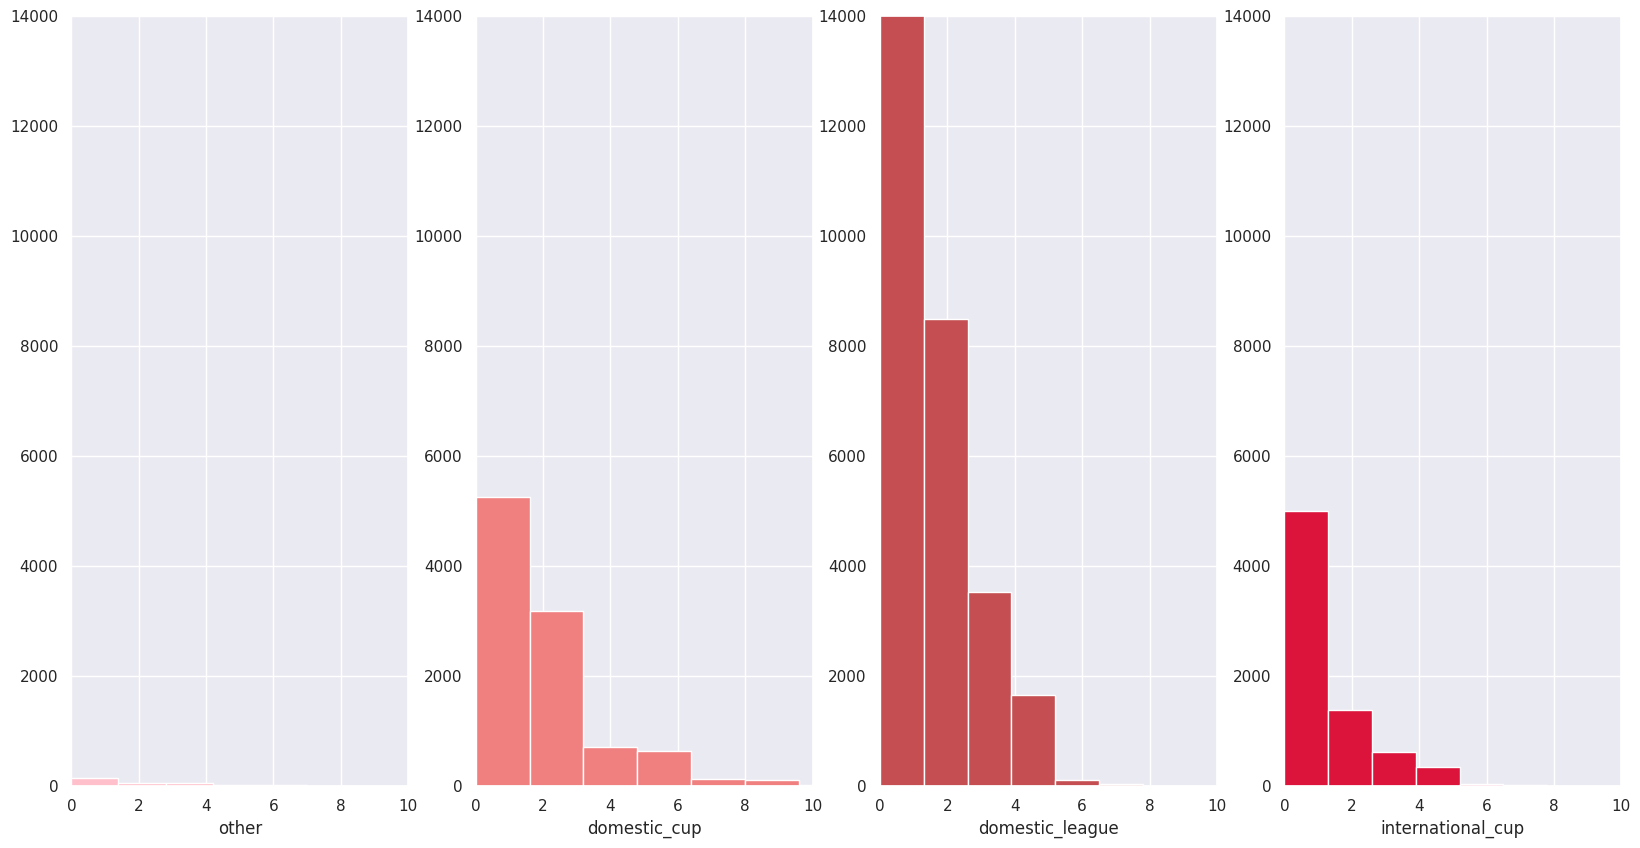

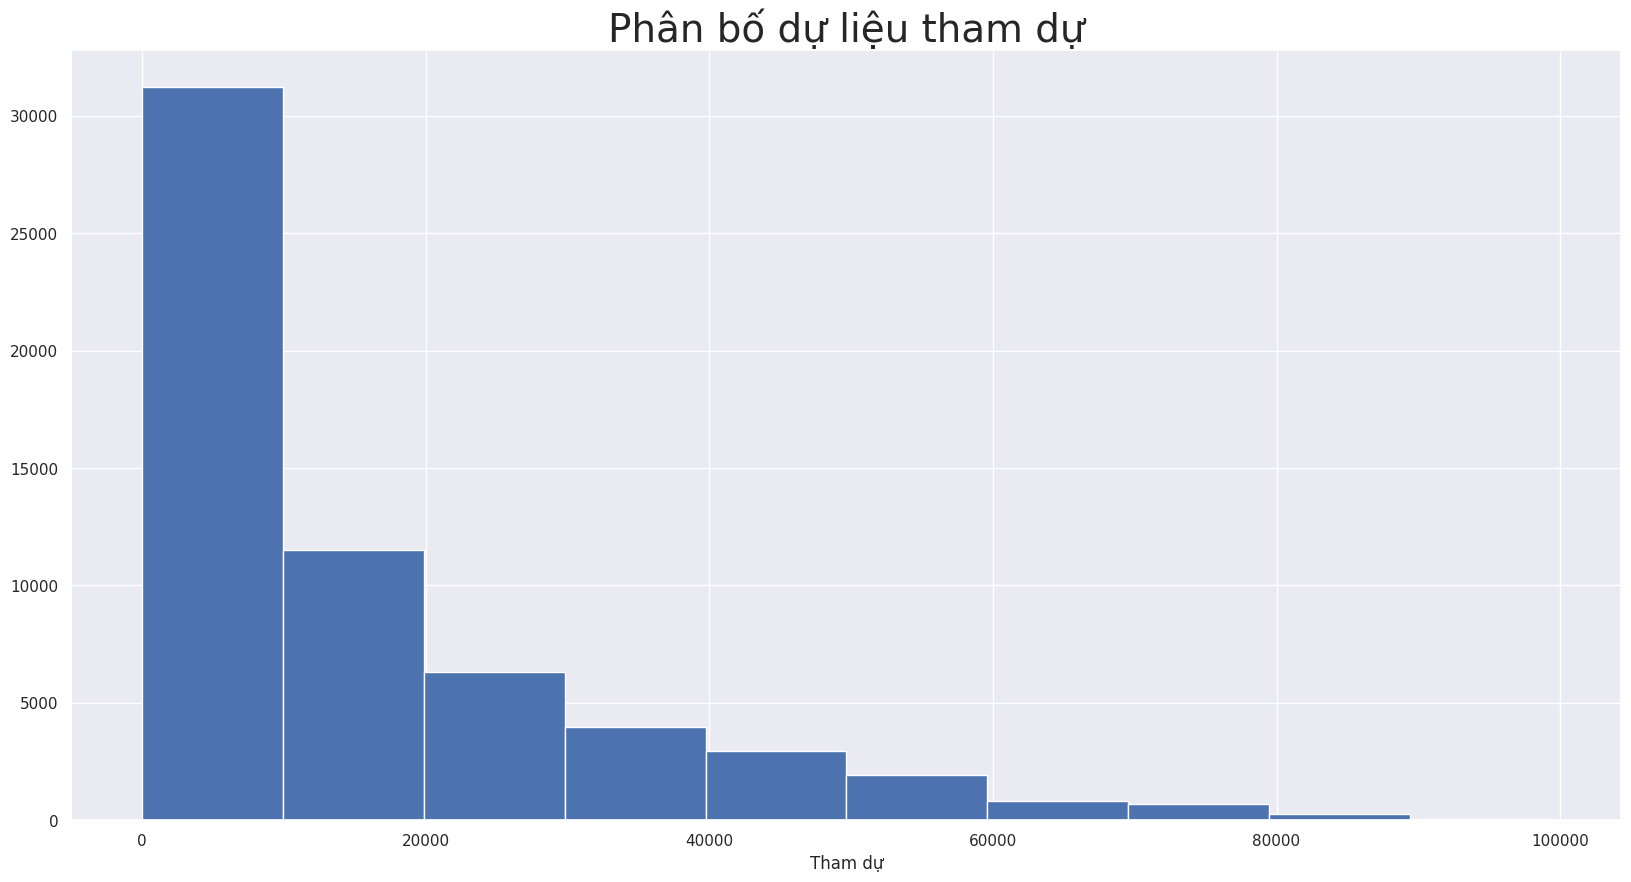

In [ ]:
#print(games_df.columns) ; print(games_df.shape)

#Thêm năm vào giá trị file games
games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
games_df['year']=games_df['datetime'].dt.year

#phạm vi bộ lọc
games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]

# Thành tích bàn thắng sân nhà và sân khách
plt.title('Thành tích bàn thắng sân nhà và sân khách',fontsize=28)
yeargroups1 = games_df.loc[:,['home_club_goals', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups2 = games_df.loc[:,['away_club_goals', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
plt.plot(yeargroups1.index,yeargroups1,color='blue',label='Bàn thắng sân nhà')
plt.plot(yeargroups2.index,yeargroups2,color='red',label='Bàn thắng sân khách')
plt.legend()
plt.show()

#bàn thắng trên sân nhà theo giải đấu
n=1;colour=['b','lightblue','cornflowerblue','b','navy']
competition_type=games_df.competition_type.unique()
for type in competition_type:
    plt.subplot(1,4,n);n=n+1
    games_df1 = games_df[(games_df.competition_type==type)] 
    plt.hist(games_df1['home_club_goals'],color=colour[n-1])
    plt.ylim(0,14000);plt.xlim(0,10)
    plt.xlabel(type)
plt.show()

#bàn thắng trên sân khách theo giải đấu
n=1;colour=['yellow','pink','lightcoral','r','crimson','brick']
for type in competition_type:
    plt.subplot(1,4,n);n=n+1
    games_df1 = games_df[(games_df.competition_type==type)] 
    plt.hist(games_df1['away_club_goals'],color=colour[n-1])
    plt.ylim(0,14000);plt.xlim(0,10)
    plt.xlabel(type)
plt.show()

# phân bố theo dữ liệu thuộc tính tham dự
plt.hist(games_df['attendance'])
plt.title('Phân bố dự liệu tham dự',fontsize=28)
plt.xlabel('Tham dự')
plt.show()

# Dữ liệu tham dự theo năm
# n=1;colour=['yellow','r','orange','b','g'];years=games_df['year'].unique()
# for year in years:
#    plt.subplot(1,len(years),n);n=n+1
#    attendance_df1 = games_df[(games_df.year==year)]                                             
#    plt.hist(attendance_df1['attendance'])
#    plt.ylim(0,4000)
#    plt.xlabel(year)
# plt.show()

**Trực quan hóa dữ liệu về giá trị thị trường theo độ tuổi cầu thủ**

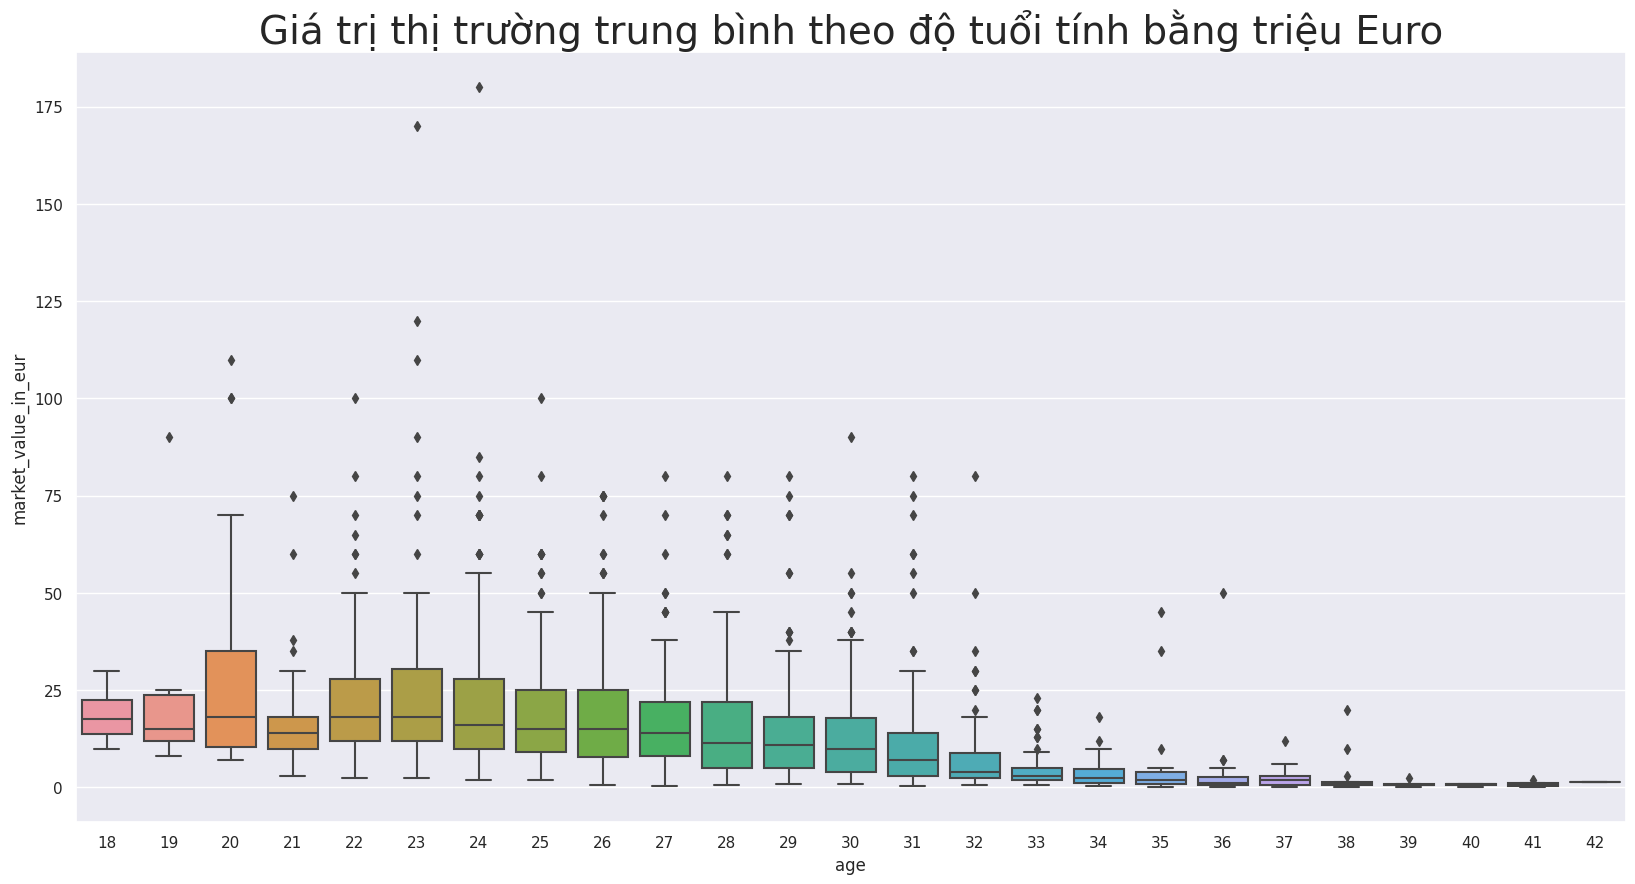

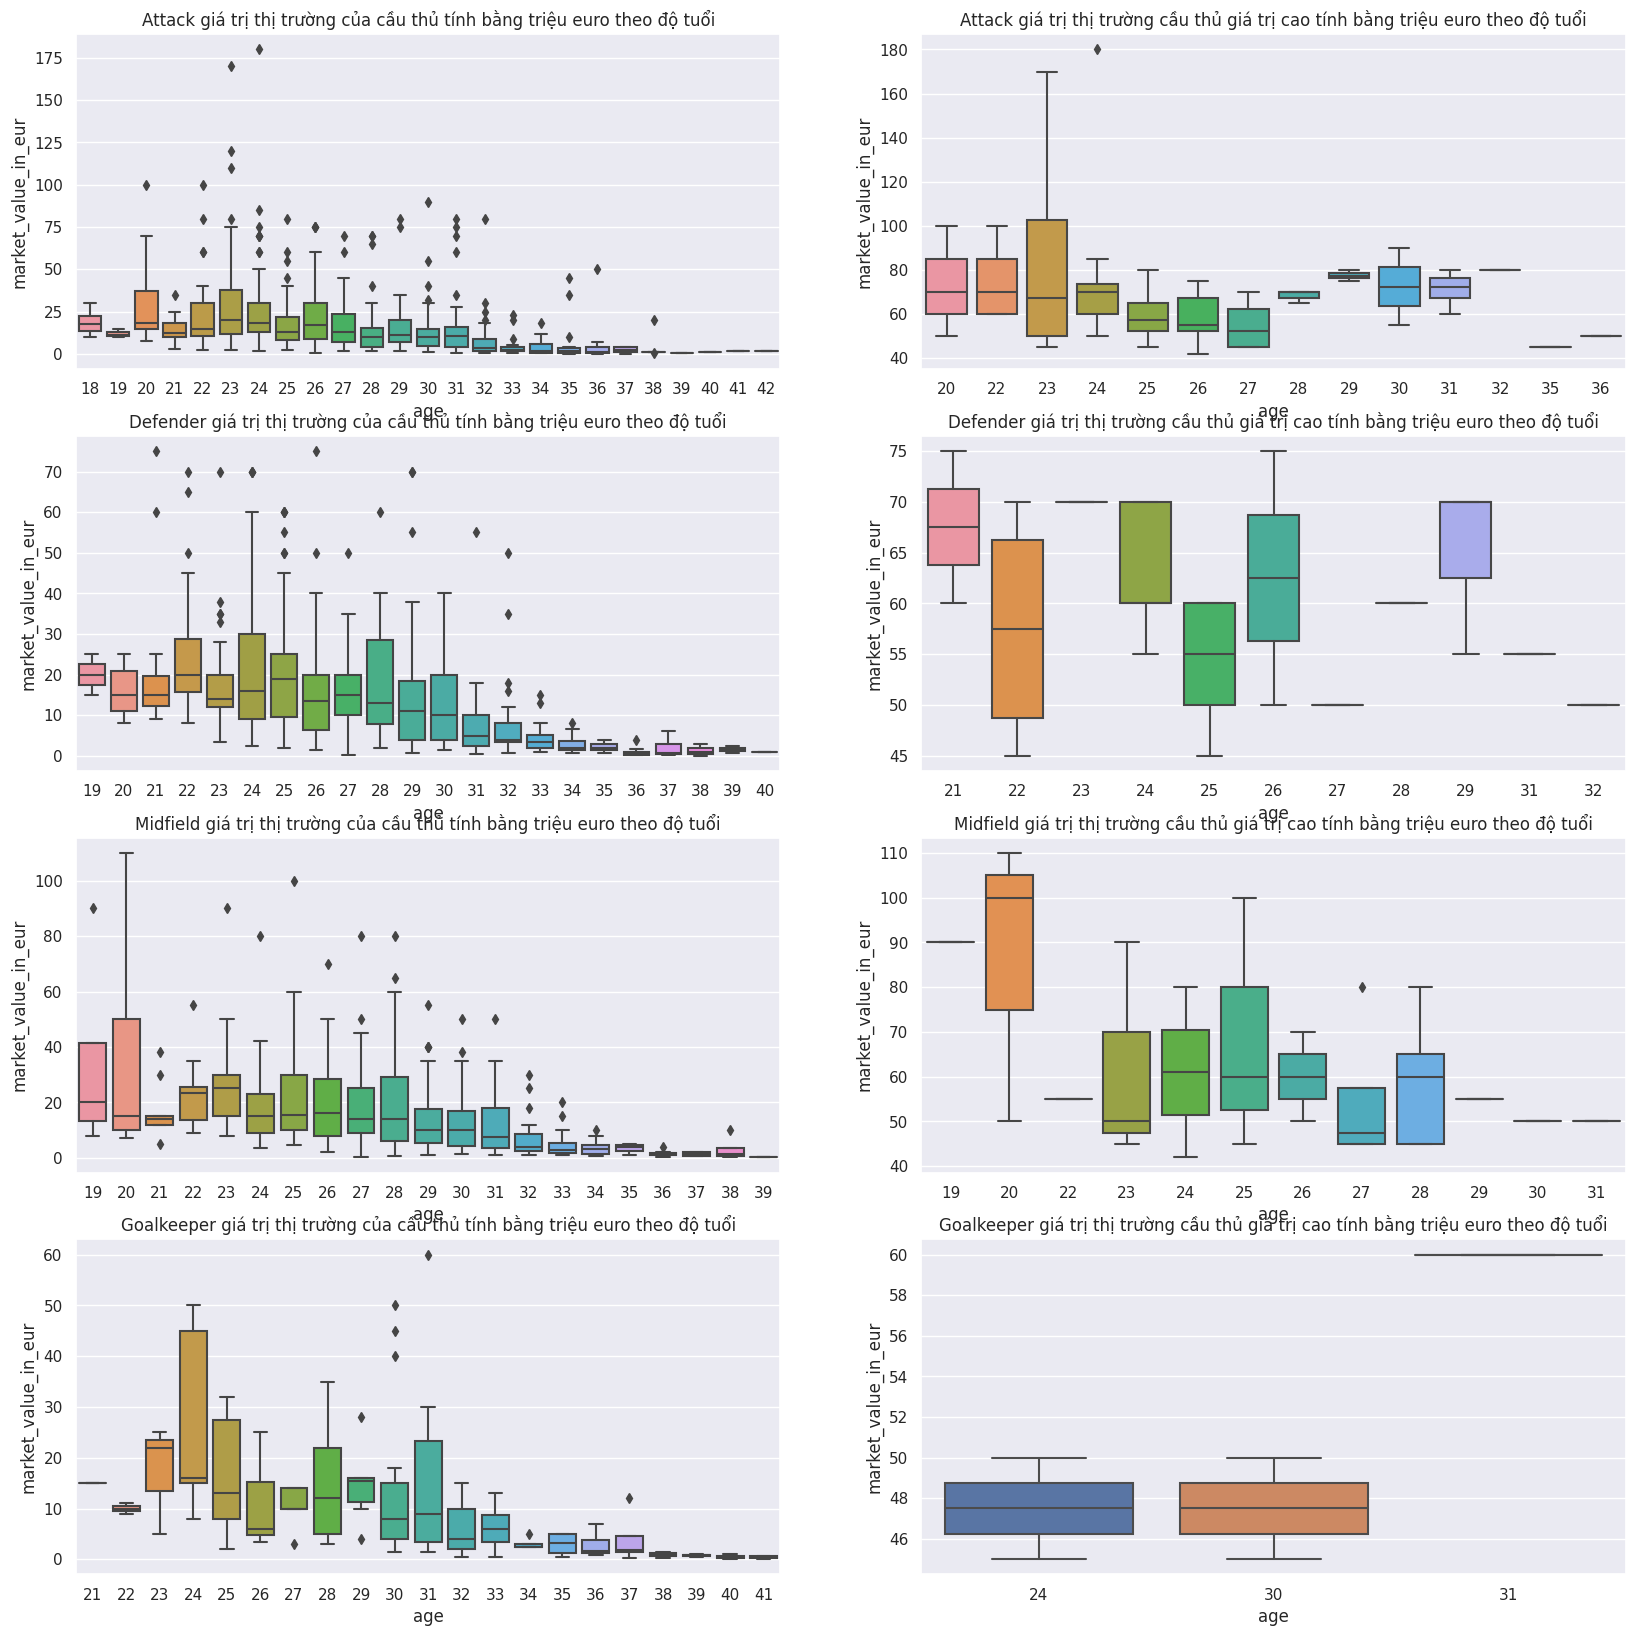

In [ ]:
#giá trị thị trường theo độ tuổi cầu thủ
agegroups = players_df1.loc[:,['market_value_in_eur', 'age']] \
    .groupby(['age']) \
    .mean() \
    .sort_values(by='market_value_in_eur', ascending=False)
sns.set(rc={'figure.figsize':(20,10)})
plt.ylabel('Market value')
sns.boxplot(x=players_df1["age"], y=(players_df1['market_value_in_eur'])/1000000)
plt.title('Giá trị thị trường trung bình theo độ tuổi tính bằng triệu Euro',fontsize=28)
plt.show() 
# hiển thị Giá trị thị trường cho từng vị trí theo độ tuổi
positions=players_df1.position.unique()
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(421);ax2 = f.add_subplot(422);ax3 = f.add_subplot(423);ax4 = f.add_subplot(424)
ax5 = f.add_subplot(425);ax6 = f.add_subplot(426);ax7 = f.add_subplot(427);ax8 = f.add_subplot(428)
n=1
for position in positions:
    plt.subplot(4,2,n); n=n+1 
    players_df2 = players_df1[players_df1['position'] == position]
    agegroups = players_df2.loc[:,['market_value_in_eur', 'age']].groupby(['age']).median().sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=players_df2["age"], y=(players_df2['market_value_in_eur'])/1000000)
    title=str(position+' giá trị thị trường của cầu thủ tính bằng triệu euro theo độ tuổi');plt.title(title)
    plt.subplot(4,2,n); n=n+1
    high_value_players_df2 = high_value_players_df[high_value_players_df['position'] == position]
    agegroups = high_value_players_df.loc[:,['market_value_in_eur', 'age']].groupby(['age']).median().sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=high_value_players_df2["age"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    title=str(position+' giá trị thị trường cầu thủ giá trị cao tính bằng triệu euro theo độ tuổi'); plt.title(title)
plt.show()

**Trực quan hóa dữ liệu về giá trị thị trường theo chiều caot**

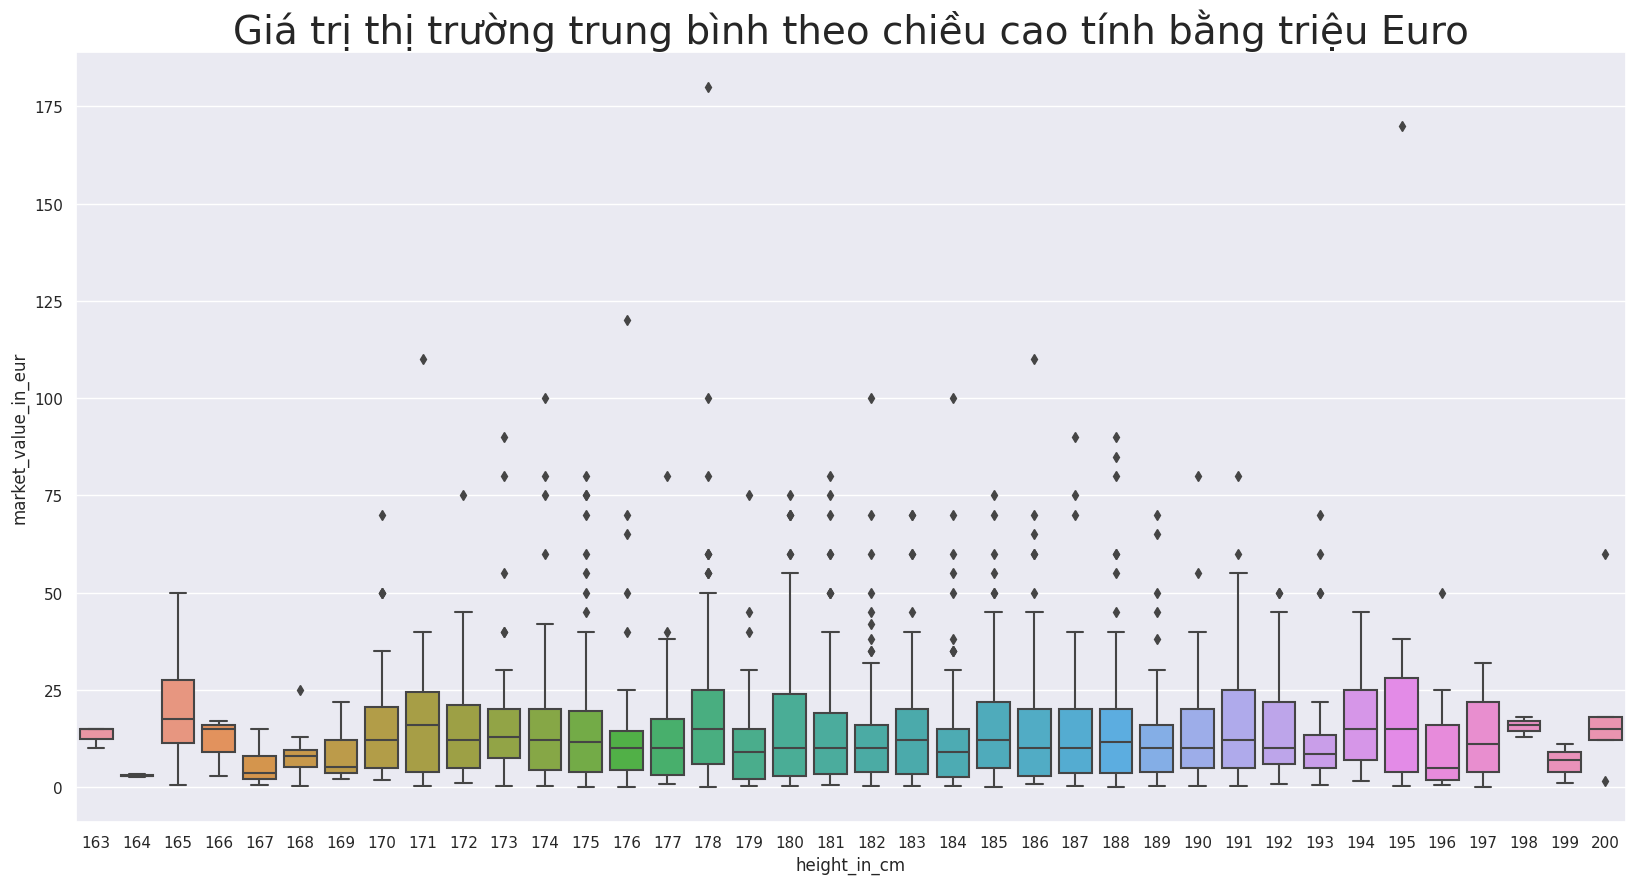

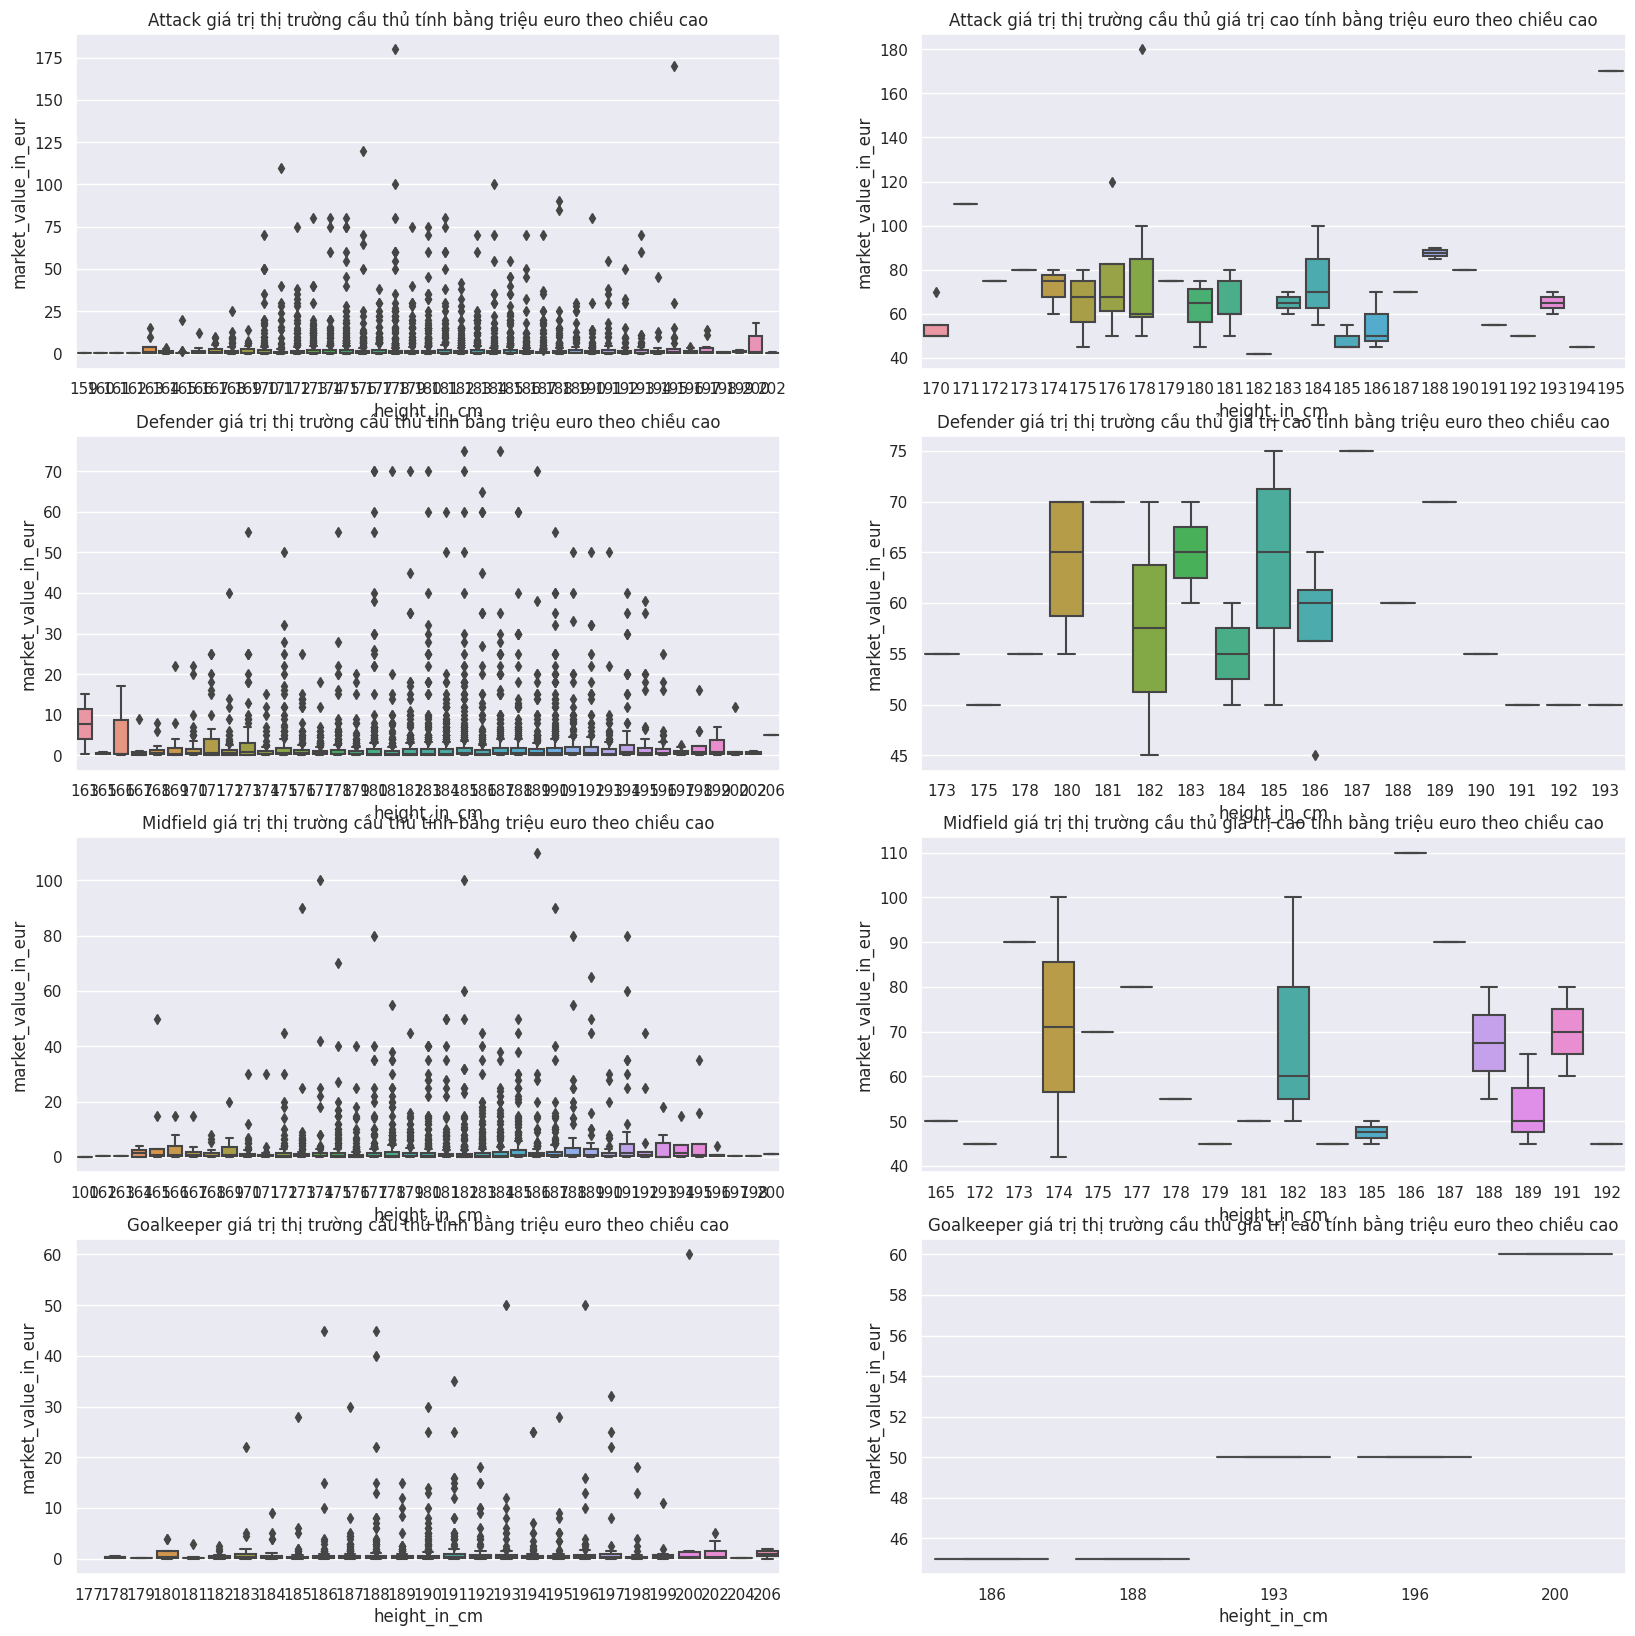

In [ ]:
# Bỏ những dòng cầu thủ không có dữ liệu về chiều cao
players_df3 = players_df[players_df['height_in_cm'] >= 1]

#Gía trị thị trường cầu thủ theo chiều cao
heightgroups = players_df1.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .mean() \
    .sort_values(by='market_value_in_eur', ascending=False)
sns.set(rc={'figure.figsize':(20,10)})
plt.ylabel('Gía trị thị trường')
sns.boxplot(x=players_df1["height_in_cm"], y=(players_df1['market_value_in_eur'])/1000000)
plt.title('Giá trị thị trường trung bình theo chiều cao tính bằng triệu Euro', fontsize=28)
plt.show() 

#Giá trị thị trường trung bình theo chiều cao cầu thủ tính bằng triệu Euro
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(421);ax2 = f.add_subplot(422);ax3 = f.add_subplot(423);ax4 = f.add_subplot(424)
ax5 = f.add_subplot(425);ax6 = f.add_subplot(426);ax7 = f.add_subplot(427);ax8 = f.add_subplot(428)

n=1
for position in positions:
    plt.subplot(4,2,n)
    n=n+1 
    players_df4 = players_df3[players_df3['position'] == position]
    heightgroups = players_df4.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .median() \
    .sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=players_df4["height_in_cm"], y=(players_df4['market_value_in_eur'])/1000000)
    title=str(position+' giá trị thị trường cầu thủ tính bằng triệu euro theo chiều cao')
    plt.title(title)
    plt.subplot(4,2,n); n=n+1
    high_value_players_df2 = high_value_players_df[high_value_players_df['position'] == position]
    heightgroups = high_value_players_df2.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .median() \
    .sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=high_value_players_df2["height_in_cm"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    title=str(position+' giá trị thị trường cầu thủ giá trị cao tính bằng triệu euro theo chiều cao')
    plt.title(title)
plt.show()

**Những cầu thủ thuộc top theo giá trị thị trường chuyển nhượng**

In [ ]:
high_value_players_df2=high_value_players_df1.sort_values('market_value_in_eur',ascending = False)
highest_value_players_df2=high_value_players_df1.sort_values('highest_market_value_in_eur',ascending = False)

print((high_value_players_df2[['name',"market_value_in_eur"]]).head(15));print("*****")
print(highest_value_players_df2[['name',"highest_market_value_in_eur"]].head(15));print("*****")

                      name  market_value_in_eur
25338        Kylian Mbappé          180000000.0
25273       Erling Haaland          170000000.0
26532      Vinicius Junior          120000000.0
26907      Jude Bellingham          110000000.0
25276           Phil Foden          110000000.0
26579    Federico Valverde          100000000.0
26734                Pedri          100000000.0
24826          Bukayo Saka          100000000.0
22185        Jamal Musiala          100000000.0
26742                 Gavi           90000000.0
24837           Harry Kane           90000000.0
26573  Aurélien Tchouameni           90000000.0
23302          Rafael Leão           85000000.0
25304        Mohamed Salah           80000000.0
25298       Bernardo Silva           80000000.0
*****
                         name  highest_market_value_in_eur
25338           Kylian Mbappé                  200000000.0
25340            Lionel Messi                  180000000.0
25397                  Neymar                  18

**Tổng quan thống kê**

In [ ]:
#Hiện các thông tin và mô tả trong dataframes
for i, df in enumerate(dataframes):
    print("***********")
    print(df.info())
    print(df.describe())

***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151986 entries, 0 to 1151985
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   appearance_id           1151986 non-null  object
 1   game_id                 1151986 non-null  int64 
 2   player_id               1151986 non-null  int64 
 3   player_club_id          1151986 non-null  int64 
 4   player_current_club_id  1151986 non-null  int64 
 5   date                    1140047 non-null  object
 6   player_name             1151757 non-null  object
 7   competition_id          1151986 non-null  object
 8   yellow_cards            1151986 non-null  int64 
 9   red_cards               1151986 non-null  int64 
 10  goals                   1151986 non-null  int64 
 11  assists                 1151986 non-null  int64 
 12  minutes_played          1151986 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 114.3+ MB
None
        

**Đối chiếu tất cả dữ liệu của các cầu thủ**

In [ ]:
# Điều này là do nổ lực đối chiếu tất cả dữ liệu của cầu thủ và đã tìm thấy một giải pháp tinh tế hơn nhiều từ LOIS CORDEIRO

#Bắt đầu với file dữ liệu players
merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 'last_name', 'player_code', 'image_url', 'url'], axis=1)

#Tiếp theo nỗi dữ liệu với dữ liệu file clubs
merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + ['club_value','squad_size','goals','goals_2022','games_2022','assists_2022','minutes_played_2022','goals_against_2022','goals_for_2022','clean_sheet_2022'])
for player_id in merged_players_df.player_id.unique():
    #print(players_df.current_club_id[(players_df.player_id==player_id)])
    club_id= players_df.current_club_id[(players_df.player_id==player_id)]
    #print(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    #print(clubs_df.squad_size[(clubs_df.club_id==int(club_id))])
    try:
        merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    except:
        merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
    merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))
#Sắp xếp lại các cột
columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022','clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship','country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name','contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur']
merged_players_df=merged_players_df[columns]
#print(merged_players_df.head())

#merge games and appearances
#Gộp dữ liệu của 2 files games và appearances
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
print('Dữ liệu giữa 2 files games và appearances đã gộp thành công');#print(games_and_appearances_df.shape);print(games_and_appearances_df.columns);print(games_and_appearances_df.head(1))

Dữ liệu giữa 2 files games và appearances đã gộp thành công


In [ ]:
#đối chiếu số liệu thống kê từ files games, appearances và ngày ghi bàn của mỗi cầu thủ
#Code được viết dựa trên code của "luis gasparcordeiro": https://www.kaggle.com/code/luisgasparcordeiro/market-value-eda/notebook

# Gộp dữ liệu từ 2 files games và appearances 
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
season = 2022 

#Tạo 1 hàm để để đối chiếu số liệu các cầu thủ
def player_stats(player_id, season, df):
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[ df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for','goals_against','clean_sheet','yellow_cards','red_cards'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else 0 if row['goals_against'] > 0
            else np.nan, axis=1)
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                      'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum','red_cards':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df
#print(player_stats(67064, 2014, games_and_appearances_df)) #test function works.

#Vòng lặp hiện kết quả thống kê về các cầu thủ
for index in merged_players_df.index:
    id = merged_players_df.loc[index][0]
    #print(id)
    name = merged_players_df.loc[index][1]
    stats = player_stats(id, season, games_and_appearances_df)
    try:
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
    except:
        #print(id)
        n=n+1     
print('Dữ liệu về cầu thủ ra sân, bàn thắng, số thẻ từ dữ liệu đã gộp')
print(merged_players_df.info());#print(merged_players_df.describe())

Dữ liệu về cầu thủ ra sân, bàn thắng, số thẻ từ dữ liệu đã gộp
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17245 entries, 6 to 28488
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             17245 non-null  int64         
 1   games_2022                            17245 non-null  float64       
 2   minutes_played_2022                   17245 non-null  float64       
 3   goals_2022                            17245 non-null  float64       
 4   assists_2022                          17245 non-null  float64       
 5   goals_against_2022                    17245 non-null  float64       
 6   goals_for_2022                        17245 non-null  float64       
 7   clean_sheet_2022                      17245 non-null  float64       
 8   name                                  17245 non-null  object        
 9   position 

**Pairplots**

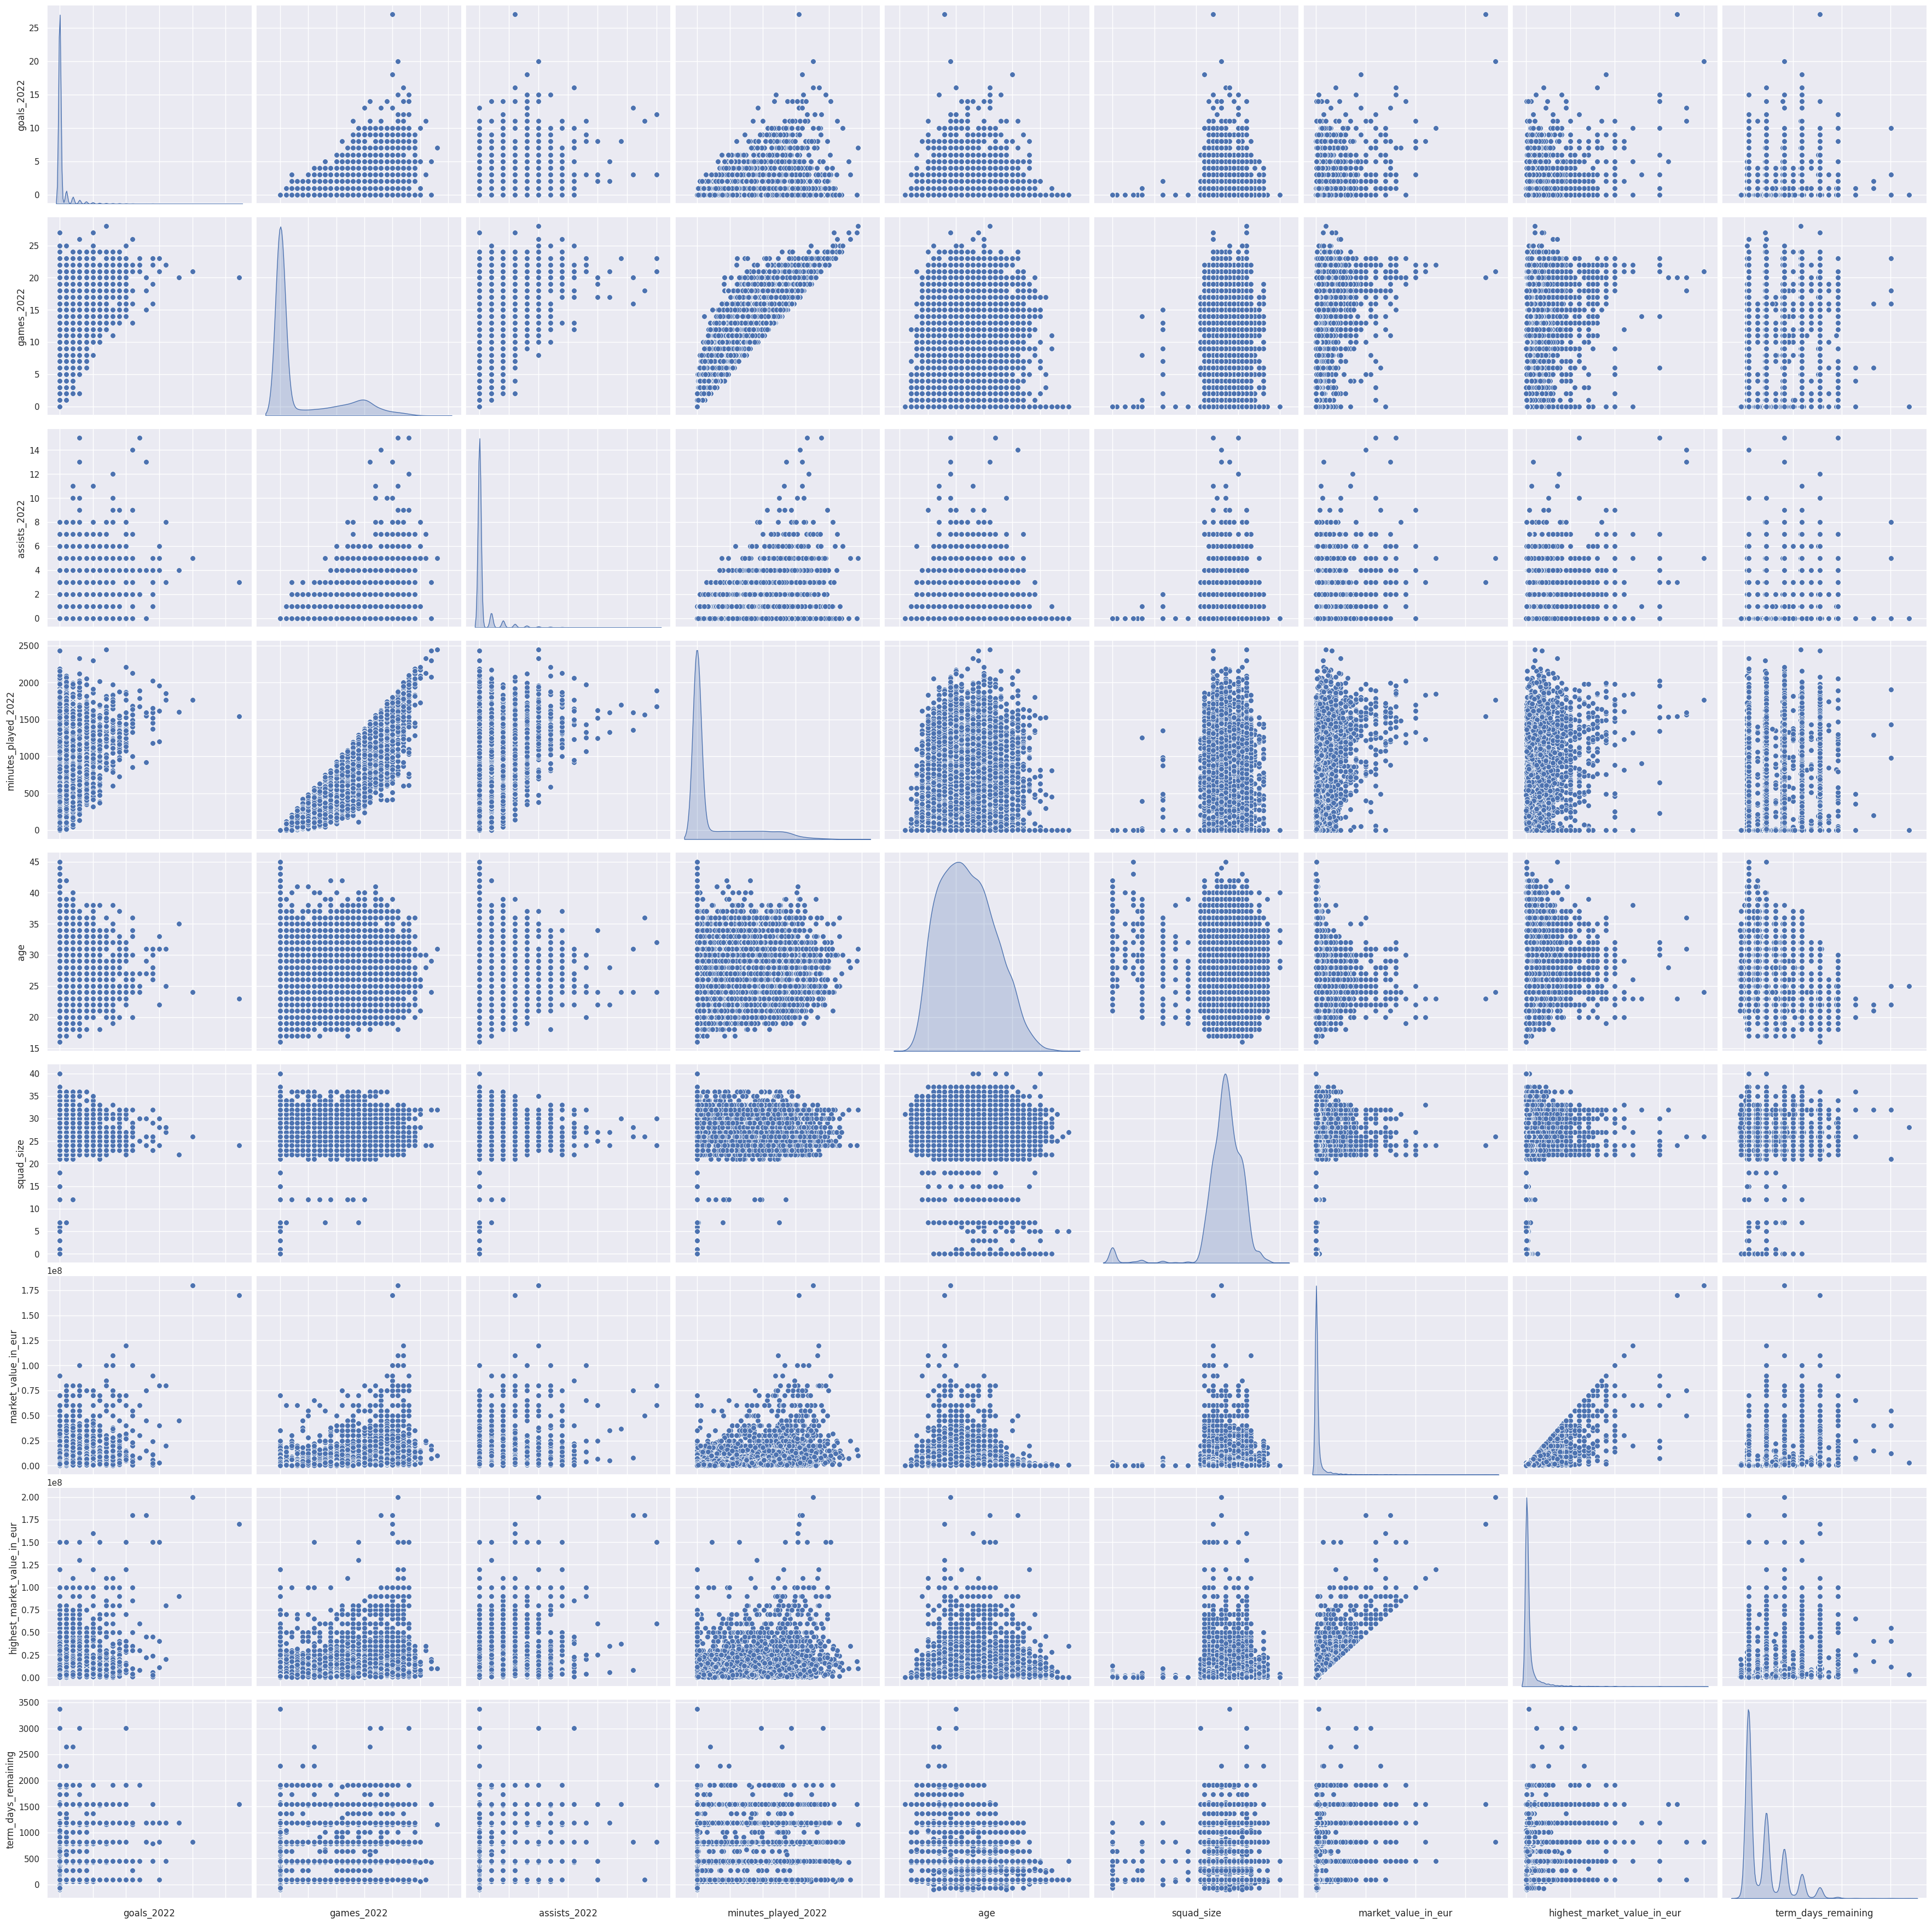

In [ ]:
g = sns.pairplot(merged_players_df[[u'goals_2022', u'games_2022', u'assists_2022', u'minutes_played_2022',u'age',u'squad_size',u'market_value_in_eur',u'highest_market_value_in_eur',u'term_days_remaining']], palette = 'seismic',size=4,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])

**Pearson Correlation of Features**

Index(['games_2022', 'minutes_played_2022', 'goals_2022', 'assists_2022', 'goals_against_2022', 'goals_for_2022', 'clean_sheet_2022', 'age', 'club_value', 'squad_size', 'term_days_remaining', 'market_value_in_eur', 'highest_market_value_in_eur', 'yellow_cards_2022', 'red_cards_2022'], dtype='object')


<Axes: title={'center': 'Tương quan của các tính năng'}>

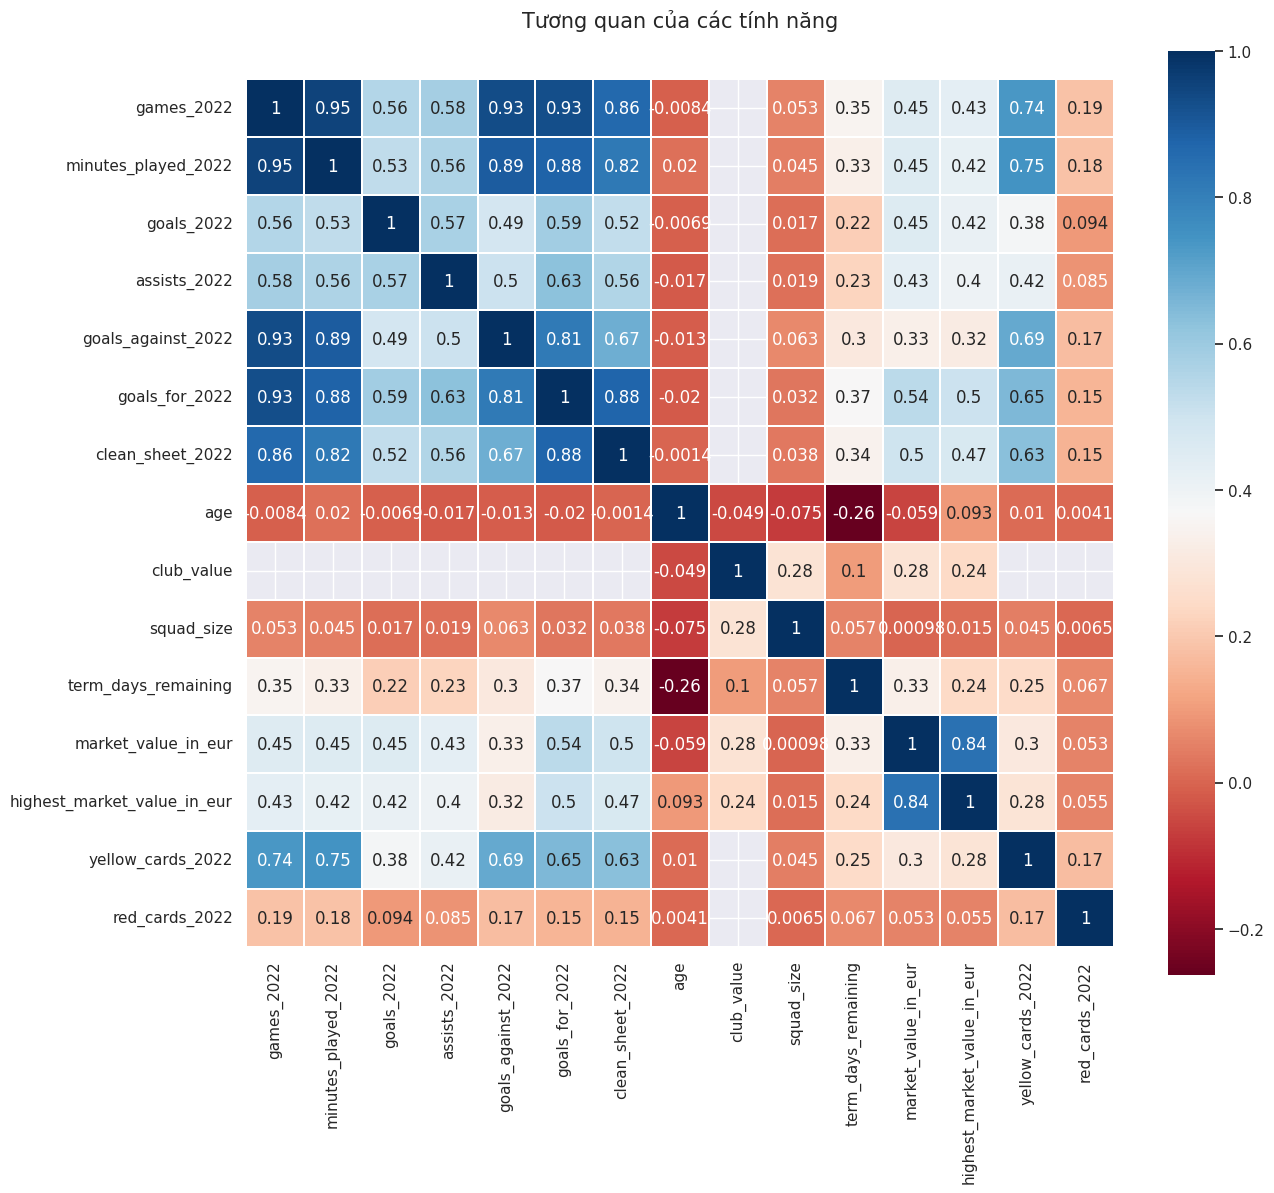

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Tương quan của các tính năng', y=1.05, size=15)
features_df=merged_players_df.drop(['player_id','name','position','sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date'],axis=1)
print(features_df.columns)
sns.heatmap(features_df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

**Tạo mô hình đầu tiên**

**SVR**

In [ ]:
#Tách các cột riêng biệt
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size']
OTHER_COLUMNS=['position','sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
#bỏ những dòng dữ liệu có giá trị NaN(missing values)
merged_players_df=merged_players_df.dropna(subset=['market_value_in_eur'])
#Tạo 2 biến dữ liệu là test và train
X = merged_players_df[NUMERIC_COLUMNS].fillna(-1000)
y=merged_players_df['market_value_in_eur']
#Tách dữ liệu test và train từ biến X, y đã tạo 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
#Mô hình dữ liệu
clf = SVR(kernel="linear")
clf.fit(X_train, y_train)
#đánh giá độ chính xác của mô hình
print("Độ chính xác của SVR: {}".format(clf.score(X_test, y_test)))
#tạo dự đoán về dữ liệu mô hình
test = X_test[NUMERIC_COLUMNS].fillna(-1000)
Submission=clf.predict(test)
#print(Submission.head(5))

Độ chính xác của SVR: 0.08344975154382395


**Các tính năng kỹ thuật**

In [ ]:
#chỉ lọc ra những cầu thủ của giải đấu GB1
merged_players_df1 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='GB1')]
# Chuyển đổi thuộc tính position thành Cột cho dữ liệu test
dummies=pd.get_dummies(merged_players_df1[['position']], prefix_sep='_') #position
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 
print('Chuyển đổi các tính năng đã thành công') #print(merged_players_df1.head())

Chuyển đổi các tính năng đã thành công


**Đánh giá lại mô hình**

**GradientBoostingRegressor**

In [ ]:
#Tách các cột riêng biệt
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield']
OTHER_COLUMNS=['sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
#Tạo 2 biến dữ liệu là test và train
y=merged_players_df1['market_value_in_eur']
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
#Tách dữ liệu test và train từ biến X, y đã tạo 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
#Mô hình dữ liệu
clf = GradientBoostingRegressor(random_state=0)
#clf = SVR(kernel="linear",gamma="auto")
#clf = DecisionTreeRegressor(random_state=0)
clf.fit(X_train, y_train)
#đánh giá độ chính xác của mô hình
print("Độ chính xác GBR: {}".format(clf.score(X_test, y_test)))

Độ chính xác GBR: 0.6550145459850392


**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=10)

#Tách các cột riêng biệt
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield']
OTHER_COLUMNS=['sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
#Tạo 2 biến dữ liệu là test và train
y=merged_players_df1['market_value_in_eur']
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.score(X_test,y_test)


0.06442577030812324

In [ ]:
y_pred = knn.predict(X_test)

y_pred

array([4.50e+07, 2.50e+05, 5.00e+05, 2.50e+05, 3.20e+07, 1.50e+05,
       1.80e+07, 3.00e+06, 1.70e+07, 3.00e+05, 2.00e+05, 1.50e+05,
       3.50e+07, 2.50e+05, 1.00e+06, 1.70e+07, 1.00e+05, 5.00e+05,
       1.80e+07, 9.00e+06, 2.20e+07, 1.80e+07, 1.50e+05, 1.80e+07,
       2.00e+06, 4.50e+07, 8.00e+06, 3.00e+05, 1.50e+05, 9.00e+06,
       2.00e+07, 1.00e+06, 3.50e+07, 2.00e+05, 5.00e+05, 8.50e+06,
       5.00e+06, 5.00e+06, 2.00e+05, 3.00e+07, 2.50e+07, 5.00e+04,
       2.50e+05, 3.20e+07, 1.50e+05, 2.00e+05, 2.00e+06, 2.50e+05,
       5.00e+05, 2.20e+07, 8.00e+06, 2.50e+07, 1.50e+05, 2.50e+07,
       1.80e+07, 5.00e+04, 1.50e+05, 1.50e+07, 5.00e+05, 6.00e+05,
       3.00e+05, 7.00e+07, 2.50e+07, 5.00e+05, 1.50e+06, 6.00e+05,
       8.00e+05, 5.00e+06, 2.80e+07, 3.00e+06, 1.80e+07, 2.00e+05,
       2.00e+07, 5.00e+04, 2.20e+06, 2.20e+07, 2.50e+05, 2.00e+05,
       5.00e+05, 5.00e+05, 4.50e+05, 1.50e+05, 1.20e+07, 5.00e+05,
       2.50e+05, 5.50e+06, 2.00e+05, 3.20e+07, 1.70e+07, 1.80e

In [ ]:
#Thêm thư viện confusion_matrix
from sklearn.metrics import confusion_matrix

# Dự đoán dữ liệu bằng cách sử dựng classifier chúng ta đã cân bằng ở trên
y_pred = knn.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
#Thêm thư viện classification_report
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

     50000.0       0.00      0.00      0.00         4
     75000.0       0.00      0.00      0.00         3
    100000.0       0.00      0.00      0.00         6
    125000.0       0.00      0.00      0.00         2
    150000.0       0.07      0.25      0.11         8
    200000.0       0.12      0.22      0.15        18
    250000.0       0.08      0.27      0.12        15
    275000.0       0.00      0.00      0.00         0
    300000.0       0.08      0.07      0.07        14
    350000.0       0.00      0.00      0.00         6
    400000.0       0.00      0.00      0.00         9
    450000.0       0.00      0.00      0.00         2
    500000.0       0.06      0.22      0.10         9
    600000.0       0.00      0.00      0.00         7
    650000.0       0.00      0.00      0.00         1
    700000.0       0.00      0.00      0.00         7
    800000.0       0.00      0.00      0.00         8
    900000.0       0.00    

**SVM**

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#Tách các cột riêng biệt
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield']
OTHER_COLUMNS=['sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
#Tạo 2 biến dữ liệu là test và train
y=merged_players_df1['market_value_in_eur']
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

cls = svm.SVC(kernel="rbf", probability=True)

cls.fit(X_train,y_train)

y_pred = cls.predict(X_test)

ac = accuracy_score(y_test,y_pred)
print("Độ chính xác của SVM: {}".format(ac))

Độ chính xác của SVM: 0.09243697478991597


**Further feature engineering**

In [ ]:
# Chuyển đổi thuộc tính position thành Cột cho dữ liệu test
dummies=pd.get_dummies(merged_players_df1[['sub_position']], prefix_sep='_') #sub position
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 
dummies=pd.get_dummies(merged_players_df1[['foot']], prefix_sep='_') #foot
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 
#print(merged_players_df1[NUMERIC_COLUMNS].head())

**Đánh giá so sánh các mô hình**

0:	learn: 10550223.2172234	total: 552us	remaining: 4.97ms
1:	learn: 10252883.6010770	total: 2.13ms	remaining: 8.53ms
2:	learn: 8823116.2581603	total: 2.81ms	remaining: 6.55ms
3:	learn: 8457527.6620955	total: 3.48ms	remaining: 5.22ms
4:	learn: 8197174.3657092	total: 4.14ms	remaining: 4.14ms
5:	learn: 8096015.8150838	total: 4.78ms	remaining: 3.18ms
6:	learn: 7525913.2737155	total: 5.42ms	remaining: 2.32ms
7:	learn: 7370131.2477119	total: 6.04ms	remaining: 1.51ms
8:	learn: 7154833.3811079	total: 6.66ms	remaining: 740us
9:	learn: 7077351.2213701	total: 7.28ms	remaining: 0us


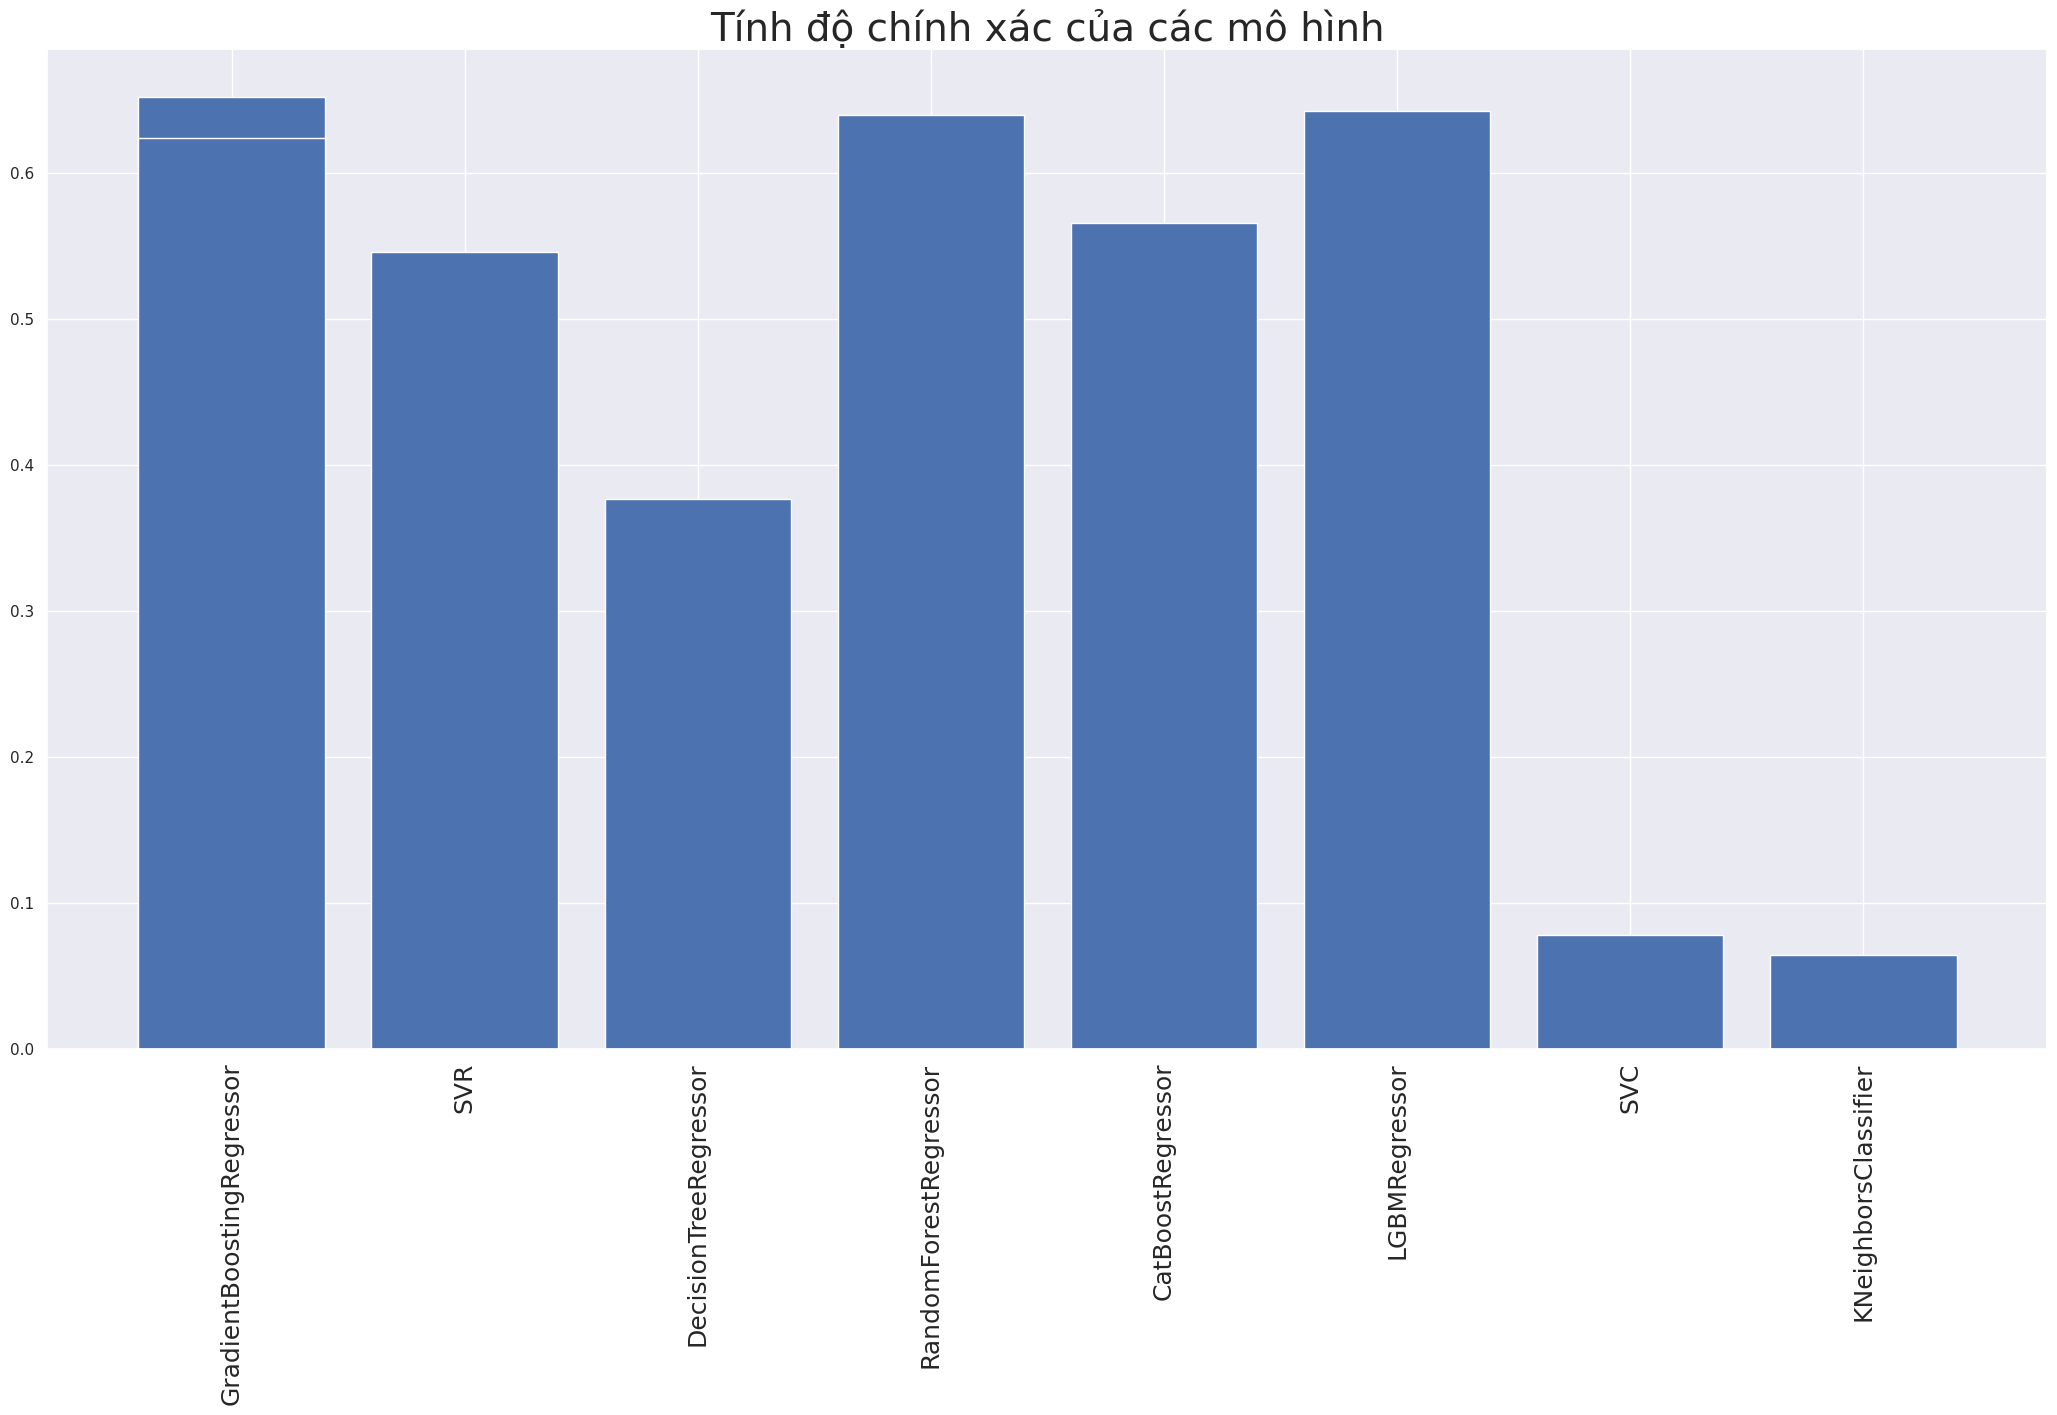

                       model  accuracy
0  GradientBoostingRegressor  0.652424
1                        SVR  0.546155
2      DecisionTreeRegressor  0.376479
3  GradientBoostingRegressor  0.623867
4      RandomForestRegressor  0.639608
5          CatBoostRegressor  0.566111
6              LGBMRegressor  0.642678
7                        SVC  0.078431
8       KNeighborsClassifier  0.064426


In [ ]:
from sklearn.svm import SVC

#Tách các cột riêng biệt
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','height_in_cm','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield','sub_position_Attacking Midfield','sub_position_Central Midfield','sub_position_Centre-Back','sub_position_Centre-Forward','sub_position_Defensive Midfield','sub_position_Left Midfield','sub_position_Left Winger','sub_position_Left-Back','sub_position_Right Midfield','sub_position_Right Winger','sub_position_Right-Back','sub_position_Second Striker','foot_Left','foot_Right','foot_Both']
OTHER_COLUMNS=['last_season','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date'] 
# Tạo 2 biến dữ liệu là test và train
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
y=merged_players_df1['market_value_in_eur']
#Tách dữ liệu test và train từ biến X, y đã tạo 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
comparisons_df = pd.DataFrame(columns=['model','accuracy'])
#Mô hình dữ liệu
gbr = GradientBoostingRegressor(random_state=0)
svr = SVR(kernel="linear",gamma="auto")
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(random_state=1)
XGBR = ensemble.GradientBoostingRegressor(n_estimators=1000, learning_rate=0.04, random_state=1)
cat= CatBoostRegressor(iterations=10,learning_rate=1,depth=3)
lgbm=LGBMRegressor()
svm = svm.SVC(kernel="rbf", probability=True)
knn = KNeighborsClassifier(n_neighbors=10)

models=[gbr,svr,dtr,XGBR,rfr,cat,lgbm,svm,knn]
for model in models:
    model.fit(X_train, y_train)
    #Tính độ chính xá của mô hình
    comparisons_df.loc[len(comparisons_df)] = [model.__class__.__name__,model.score(X_test, y_test)]
#= Tạo mô hình barchart để hiện kết quả của các mô hình
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = comparisons_df.model
y = comparisons_df.accuracy
ax.bar(x,y)
plt.xticks(fontsize=18, rotation=90)
plt.title('Tính độ chính xác của các mô hình',fontsize=28)
plt.show()
print(comparisons_df)